<a href="https://colab.research.google.com/github/AImSecure/Laboratory3/blob/main/lab/notebooks/Lab3_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratory 3 — Anomaly Detection

text

## Setup

In [1]:
# --- Check Python and pip versions ---
!python --version
!pip install --upgrade pip

Python 3.12.12
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 41.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [2]:






# --- Install required libraries ---
!pip install torch
!pip install numpy pandas scikit-learn matplotlib seaborn
!pip install tqdm

In [3]:
# --- Import libraries ---
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, log_loss
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.svm import OneClassSVM

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

from tqdm import tqdm

In [4]:
# Set device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

### Colab Pro

In [5]:
# --- Check GPU availability ---
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [6]:
# --- Check RAM availability ---
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


### Paths setup


In [7]:
# --- Mount Google Drive (for Google Colab users) ---
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# --- Define Paths ---
group = 'AImSecure'
laboratory = 'Laboratory3'

base_path = '/content/drive/MyDrive/'
project_path = base_path + f'Projects/{group}/{laboratory}/'
data_path = project_path + 'data/'
results_path = project_path + 'results/'

# Ensure directories exist
os.makedirs(project_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)
os.makedirs(results_path, exist_ok=True)

print(f"Project path: {project_path}")
print(f"Data path: {data_path}")
print(f"Results path: {results_path}")

Project path: /content/drive/MyDrive/Projects/AImSecure/Laboratory3/
Data path: /content/drive/MyDrive/Projects/AImSecure/Laboratory3/data/
Results path: /content/drive/MyDrive/Projects/AImSecure/Laboratory3/results/


In [9]:
# --- Set visual style ---
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

def save_plot(fig: plt.Figure, filename: str, path: str = "./plots/", fmt: str = "png", dpi: int = 300, close_fig: bool = False) -> None:
    """
    Save a Matplotlib figure in a specific to a specified directory.

    Args:
        fig (plt.Figure): Matplotlib figure object to save.
        filename (str): Name of the file to save (e.g., 'plot.png').
        path (str, optional): Directory path to save the figure. Defaults to './plots/'.
        fmt (str, optional): File format for the saved figure. Defaults to 'png'.
        dpi (int, optional): Dots per inch for the saved figure. Defaults to 300.

    Returns:
        None
    """
    # Ensure the directory exists
    os.makedirs(path, exist_ok=True)
    save_path = os.path.join(path, f"{filename}.{fmt}")

    # Save the figure
    fig.savefig(save_path, bbox_inches='tight', pad_inches=0.1, dpi=dpi, format=fmt)
    # plt.close(fig) # Removed to display plots in notebook

    if close_fig:
        plt.close(fig)

    print(f"Saved plot: {save_path}")

## Task 1 — Dataset Characterization and Preprocessing

text


In [10]:
# Create directory for plots
save_dir = results_path + 'images/' + 'task1_plots/'
os.makedirs(save_dir, exist_ok=True)

### Explore the dataset

Before preprocessing, we explore the data to understand the available features.

In [11]:
# Load Datasets
train_df = pd.read_csv(data_path + 'train.csv')
test_df = pd.read_csv(data_path + 'test.csv')

print("Files loaded successfully.")
print(f"Train dataset shape: {train_df.shape}")
print(f"Test dataset shape:  {test_df.shape}")

Files loaded successfully.
Train dataset shape: (18831, 43)
Test dataset shape:  (5826, 43)


In [12]:
train_df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,binary_label
0,0,udp,private,SF,28,0,0,3,0,0,...,0.36,0.65,0.36,0.00,0.09,0.0,0.56,0.0,dos,1
1,0,icmp,eco_i,SF,8,0,0,0,0,0,...,1.00,0.00,1.00,0.50,0.00,0.0,0.00,0.0,probe,1
2,0,tcp,daytime,S0,0,0,0,0,0,0,...,0.02,0.05,0.00,0.00,1.00,1.0,0.00,0.0,dos,1
3,0,tcp,http,SF,216,3396,0,0,0,0,...,1.00,0.00,0.14,0.02,0.00,0.0,0.00,0.0,normal,0
4,0,tcp,http,SF,348,277,0,0,0,0,...,1.00,0.00,0.01,0.07,0.00,0.0,0.00,0.0,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18826,0,tcp,http,SF,328,1231,0,0,0,0,...,1.00,0.00,0.02,0.02,0.00,0.0,0.00,0.0,normal,0
18827,0,tcp,http,SF,214,928,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,normal,0
18828,0,tcp,http,SF,253,11905,0,0,0,0,...,1.00,0.00,0.01,0.02,0.00,0.0,0.00,0.0,normal,0
18829,0,tcp,uucp_path,S0,0,0,0,0,0,0,...,0.05,0.07,0.00,0.00,1.00,1.0,0.00,0.0,dos,1


In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18831 entries, 0 to 18830
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     18831 non-null  int64  
 1   protocol_type                18831 non-null  object 
 2   service                      18831 non-null  object 
 3   flag                         18831 non-null  object 
 4   src_bytes                    18831 non-null  int64  
 5   dst_bytes                    18831 non-null  int64  
 6   land                         18831 non-null  int64  
 7   wrong_fragment               18831 non-null  int64  
 8   urgent                       18831 non-null  int64  
 9   hot                          18831 non-null  int64  
 10  num_failed_logins            18831 non-null  int64  
 11  logged_in                    18831 non-null  int64  
 12  num_compromised              18831 non-null  int64  
 13  root_shell      

In [14]:
test_df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,binary_label
0,0,udp,private,SF,1,0,0,0,0,0,...,0.03,0.85,1.00,0.0,0.0,0.0,0.0,0.0,normal,0
1,0,udp,private,SF,55,51,0,0,0,0,...,1.00,0.00,0.99,0.0,0.0,0.0,0.0,0.0,normal,0
2,0,tcp,login,RSTO,0,0,0,0,0,0,...,0.07,0.06,0.00,0.0,0.0,0.0,1.0,1.0,dos,1
3,0,tcp,ftp,S0,0,0,0,0,0,0,...,0.00,0.11,0.00,0.0,1.0,1.0,0.0,0.0,dos,1
4,0,tcp,courier,REJ,0,0,0,0,0,0,...,0.07,0.05,0.00,0.0,0.0,0.0,1.0,1.0,dos,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5821,0,udp,domain_u,SF,46,85,0,0,0,0,...,1.00,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal,0
5822,0,udp,domain_u,SF,45,45,0,0,0,0,...,0.89,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal,0
5823,0,udp,domain_u,SF,44,79,0,0,0,0,...,1.00,0.00,0.01,0.0,0.0,0.0,0.0,0.0,normal,0
5824,0,udp,private,SF,54,52,0,0,0,0,...,1.00,0.00,0.84,0.0,0.0,0.0,0.0,0.0,normal,0


In [15]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5826 entries, 0 to 5825
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     5826 non-null   int64  
 1   protocol_type                5826 non-null   object 
 2   service                      5826 non-null   object 
 3   flag                         5826 non-null   object 
 4   src_bytes                    5826 non-null   int64  
 5   dst_bytes                    5826 non-null   int64  
 6   land                         5826 non-null   int64  
 7   wrong_fragment               5826 non-null   int64  
 8   urgent                       5826 non-null   int64  
 9   hot                          5826 non-null   int64  
 10  num_failed_logins            5826 non-null   int64  
 11  logged_in                    5826 non-null   int64  
 12  num_compromised              5826 non-null   int64  
 13  root_shell        

In [16]:
# --- Identify Categorical and Numerical Features ---

# We exclude the label columns from the feature lists
label_cols = ['label', 'binary_label']

# Identify categorical columns (type 'object')
categorical_cols = train_df.select_dtypes(include=['object']).columns.drop(label_cols, errors='ignore').to_list()

# Identify numerical columns (any number type)
numerical_cols = train_df.select_dtypes(include=np.number).columns.drop(label_cols, errors='ignore').to_list()

print(f"\n--- Feature Types ---")
print(f"Categorical features: {categorical_cols}")
print(f"Numerical features: {len(numerical_cols)} (First 5: {numerical_cols[:5]}...)")
print(f"Label features: {label_cols}")


--- Feature Types ---
Categorical features: ['protocol_type', 'service', 'flag']
Numerical features: 38 (First 5: ['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment']...)
Label features: ['label', 'binary_label']


In [17]:
for column in ['protocol_type', 'service', 'flag']:
  print(f"{column}: {train_df[column].unique()}")

protocol_type: ['udp' 'icmp' 'tcp']
service: ['private' 'eco_i' 'daytime' 'http' 'exec' 'smtp' 'ftp_data' 'ssh'
 'domain_u' 'other' 'netbios_ns' 'urp_i' 'ecr_i' 'ftp' 'discard' 'ntp_u'
 'http_443' 'telnet' 'systat' 'Z39_50' 'name' 'finger' 'iso_tsap'
 'courier' 'netstat' 'hostnames' 'csnet_ns' 'efs' 'link' 'ctf' 'supdup'
 'auth' 'X11' 'klogin' 'IRC' 'time' 'domain' 'pop_3' 'whois' 'uucp_path'
 'vmnet' 'pop_2' 'netbios_dgm' 'nntp' 'bgp' 'uucp' 'gopher' 'nnsp'
 'kshell' 'sql_net' 'urh_i' 'ldap' 'mtp' 'sunrpc' 'rje' 'echo' 'login'
 'netbios_ssn' 'imap4' 'red_i' 'printer' 'http_8001' 'pm_dump'
 'remote_job' 'shell']
flag: ['SF' 'S0' 'REJ' 'RSTO' 'RSTR' 'S2' 'S1' 'SH' 'RSTOS0' 'S3' 'OTH']


In [18]:
# --- Check Label Distribution ---
print("\n--- Attack Label Distribution (Train) ---")
print(train_df['label'].value_counts(normalize=True) * 100)

print("\n--- Binary Label Distribution (Train) ---")
print(train_df['binary_label'].value_counts(normalize=True) * 100)

print("\n--- Attack Label Distribution (Test) ---")
print(test_df['label'].value_counts(normalize=True) * 100)

print("\n--- Binary Label Distribution (Test) ---")
print(test_df['binary_label'].value_counts(normalize=True) * 100)


--- Attack Label Distribution (Train) ---
label
normal    71.414158
dos       15.469173
probe     12.155488
r2l        0.961181
Name: proportion, dtype: float64

--- Binary Label Distribution (Train) ---
binary_label
0    71.414158
1    28.585842
Name: proportion, dtype: float64

--- Attack Label Distribution (Test) ---
label
dos       44.232750
normal    36.937865
probe     18.829386
Name: proportion, dtype: float64

--- Binary Label Distribution (Test) ---
binary_label
1    63.062135
0    36.937865
Name: proportion, dtype: float64


Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory3/results/images/task1_plots/train_multiclass_label_distribution.png


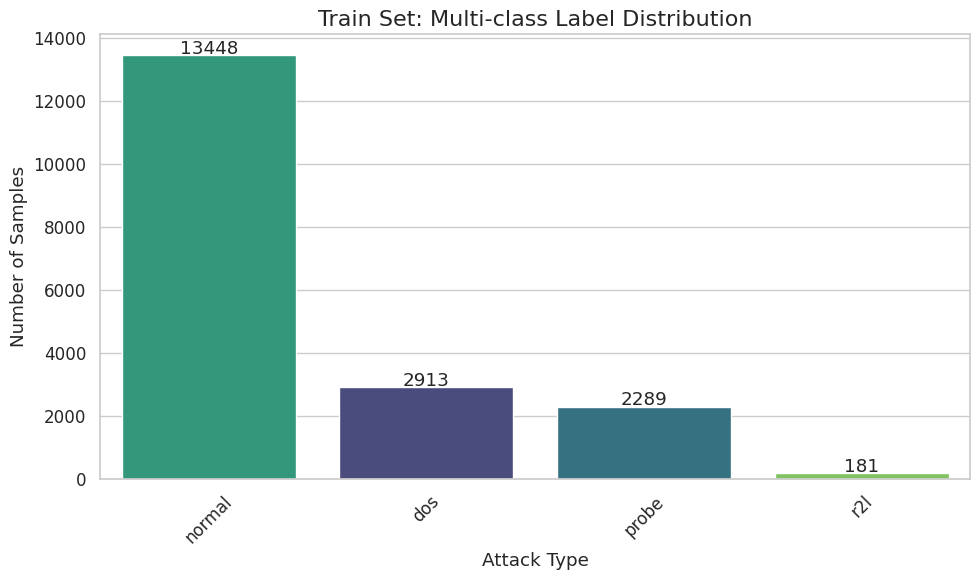

Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory3/results/images/task1_plots/train_binary_label_distribution.png


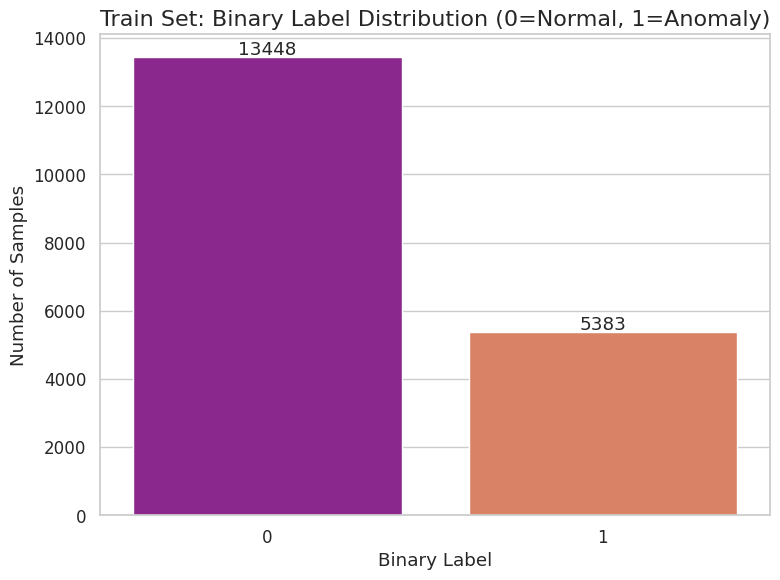

Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory3/results/images/task1_plots/test_multiclass_label_distribution.png


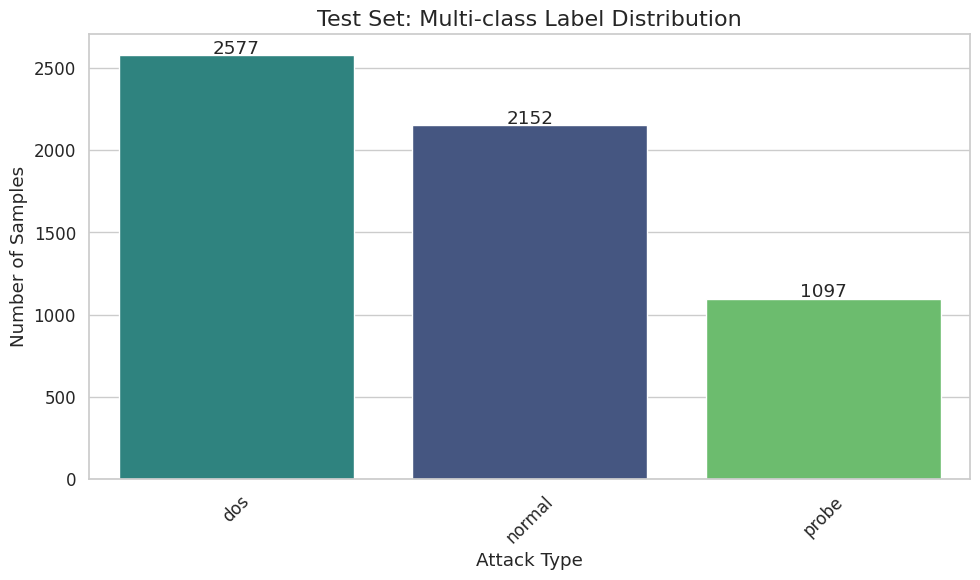

Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory3/results/images/task1_plots/test_binary_label_distribution.png


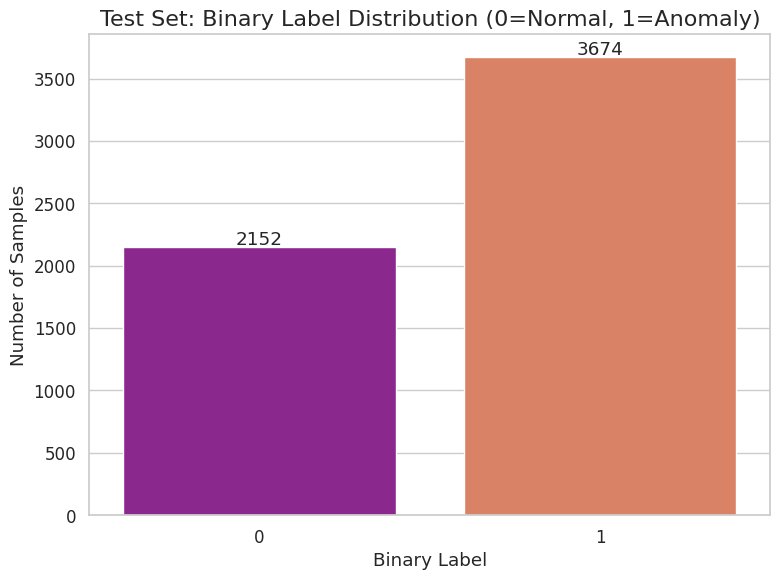

In [19]:
# Helper function to add count labels on bars
def add_counts(ax):
    for p in ax.patches:
        ax.annotate(
            f'{int(p.get_height())}',
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center',
            xytext=(0, 5),
            textcoords='offset points'
        )

# --- Plot 1: Train Set - Multi-class Label Distribution ---
plt.figure(figsize=(10, 6))
ax = sns.countplot(
    data=train_df,
    x='label',
    palette='viridis',
    order=train_df['label'].value_counts().index,
    hue='label',
    legend=False
)
plt.title('Train Set: Multi-class Label Distribution', fontsize=16)
plt.xlabel('Attack Type')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
add_counts(ax)
plt.tight_layout() # Adjust layout for this specific figure
save_plot(plt.gcf(), 'train_multiclass_label_distribution', path=save_dir, close_fig=False)
plt.show()


# --- Plot 2: Train Set - Binary Label Distribution ---
plt.figure(figsize=(8, 6))
ax = sns.countplot(
    data=train_df,
    x='binary_label',
    palette='plasma',
    hue='binary_label',
    legend=False
)
plt.title('Train Set: Binary Label Distribution (0=Normal, 1=Anomaly)', fontsize=16)
plt.xlabel('Binary Label')
plt.ylabel('Number of Samples')
add_counts(ax)
plt.tight_layout()
save_plot(plt.gcf(), 'train_binary_label_distribution', path=save_dir, close_fig=False)
plt.show()


# --- Plot 3: Test Set - Multi-class Label Distribution ---
plt.figure(figsize=(10, 6))
ax = sns.countplot(
    data=test_df,
    x='label',
    palette='viridis',
    order=test_df['label'].value_counts().index,
    hue='label',
    legend=False
)
plt.title('Test Set: Multi-class Label Distribution', fontsize=16)
plt.xlabel('Attack Type')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
add_counts(ax)
plt.tight_layout()
save_plot(plt.gcf(), 'test_multiclass_label_distribution', path=save_dir, close_fig=False)
plt.show()


# --- Plot 4: Test Set - Binary Label Distribution ---
plt.figure(figsize=(8, 6))
ax = sns.countplot(
    data=test_df,
    x='binary_label',
    palette='plasma',
    hue='binary_label',
    legend=False
)
plt.title('Test Set: Binary Label Distribution (0=Normal, 1=Anomaly)', fontsize=16)
plt.xlabel('Binary Label')
plt.ylabel('Number of Samples')
add_counts(ax)
plt.tight_layout()
save_plot(plt.gcf(), 'test_binary_label_distribution', path=save_dir, close_fig=False)
plt.show()

In [20]:
print("\n--- Value Counts for Training Data ---")
for col in ['protocol_type', 'service', 'flag']:
    print(f"\n{col} (Train):")
    print(train_df[col].value_counts())

print("\n--- Value Counts for Test Data ---")
for col in ['protocol_type', 'service', 'flag']:
    print(f"\n{col} (Test):")
    print(test_df[col].value_counts())


--- Value Counts for Training Data ---

protocol_type (Train):
protocol_type
tcp     14204
udp      3010
icmp     1617
Name: count, dtype: int64

service (Train):
service
http         7831
private      2036
domain_u     1820
smtp         1411
ftp_data     1191
             ... 
red_i           3
pm_dump         3
printer         2
shell           2
http_8001       1
Name: count, Length: 65, dtype: int64

flag (Train):
flag
SF        14907
S0         1765
REJ        1359
RSTR        497
RSTO        112
S1           87
SH           42
S2           21
RSTOS0       21
S3           15
OTH           5
Name: count, dtype: int64

--- Value Counts for Test Data ---

protocol_type (Test):
protocol_type
tcp     3282
udp     1707
icmp     837
Name: count, dtype: int64

service (Test):
service
private     1369
ecr_i        664
http         660
domain_u     549
other        532
            ... 
ntp_u          1
pop_2          1
shell          1
tim_i          1
tftp_u         1
Name: count, Length:

#### Q: What are the dataset characteristics? How many categorical and numerical attributes do you have? How are your attack labels and binary label distributed?

The dataset characteristics are as follows:

- **Dataset Shape**: The training dataset `train_df` has 18,831 rows and 43 columns, while the testing dataset `test_df` has 5,826 rows and 43 columns.

- **Attribute Types**:
  - There are **3 categorical features**: `protocol_type`, `service`, and `flag`.
  - There are **38 numerical features**.
  - The label features are `label` and `binary_label`.

- **Attack Label Distribution (Train Set)**:
  - `normal`: 71.41%
  - `dos`: 15.47%
  - `probe`: 12.16%
  - `r2l`: 0.96%

- **Binary Label Distribution (Train Set)**:
  - `normal (0)`: 71.41%
  - `anomaly (1)`: 28.59%

- **Attack Label Distribution (Test Set)**:
  - `dos`: 44.23%
  - `normal`: 36.94%
  - `probe`: 18.83%

- **Binary Label Distribution (Test Set)**:
  - `anomaly (1)`: 63.06%
  - `normal (0)`: 36.94%

### Preprocessing

Preprocess features before performing any AI/ML algorithms.

In [21]:
# Create independent copies to ensure we don't modify the original dataframes
train_val_proc_df = train_df.copy()
test_proc_df = test_df.copy()

# Separate labels immediately to prevent labels scaling/encoding
y_train_full_attack = train_val_proc_df.pop('label')
y_train_full_binary = train_val_proc_df.pop('binary_label')
y_test_attack = test_proc_df.pop('label')
y_test_binary = test_proc_df.pop('binary_label')

In [22]:
# Remove duplicates
print("Initial number of rows:", train_val_proc_df.shape[0])
train_val_proc_df = train_val_proc_df.drop_duplicates()
print("Number of rows after duplicates:", train_val_proc_df.shape[0])

# Remove rows with missing values
train_val_proc_df = train_val_proc_df.dropna()
print("Number of rows after missing values:", train_val_proc_df.shape[0])

# Now drop the instances with inifinite values
train_val_proc_df = train_val_proc_df.replace([np.inf, -np.inf], np.nan).dropna()
print("Number of rows after removing infinite values:", train_val_proc_df.shape[0])

Initial number of rows: 18831
Number of rows after duplicates: 18830
Number of rows after missing values: 18830
Number of rows after removing infinite values: 18830


In [23]:
print(f"Initial Feature Count: {train_val_proc_df.shape[1]}")

Initial Feature Count: 41


In [24]:
# --- Feature Selection: Drop Zero-Variance Columns ---

# Columns with 0 variance (all values are the same) provide no information to the model.
cols_to_drop = []
for col in numerical_cols:
    if train_val_proc_df[col].std() == 0:
        cols_to_drop.append(col)

print(f"Zero-variance columns: {cols_to_drop}")

# Drop them from both sets
train_val_proc_df.drop(columns=cols_to_drop, inplace=True)
test_proc_df.drop(columns=cols_to_drop, inplace=True)

# Update numerical list after dropping
numerical_cols = [c for c in numerical_cols if c not in cols_to_drop]
print(f"Dropped {len(cols_to_drop)} zero-variance columns: {cols_to_drop}")

Zero-variance columns: ['urgent', 'num_outbound_cmds', 'is_host_login']
Dropped 3 zero-variance columns: ['urgent', 'num_outbound_cmds', 'is_host_login']


In [25]:
# Align y_train_full_attack and y_train_full_binary with train_val_proc_df's current index
y_train_full_attack = y_train_full_attack.loc[train_val_proc_df.index]
y_train_full_binary = y_train_full_binary.loc[train_val_proc_df.index]

train_proc_df, val_proc_df = train_test_split(
    train_val_proc_df,
    train_size=0.8,
    stratify=y_train_full_attack,
    random_state=42
)

In [26]:
# Define the allowed list of services
allowed_services = ["http", "private", "smtp", "domain_u", "other", "ftp_data", "ecr_i", "eco_i"]

# Apply the mapping WARNING we increase the diversity in in the "other" class
train_proc_df["service"] = train_proc_df["service"].apply(lambda x: x if x in allowed_services else "other")
val_proc_df["service"] = val_proc_df["service"].apply(lambda x: x if x in allowed_services else "other")
test_proc_df["service"] = test_proc_df["service"].apply(lambda x: x if x in allowed_services else "other")

In [27]:
# Define the allowed list of flags
allowed_flag = ["SF", "S0", "REJ","RSTR","RSTO"]

# Apply the mapping
train_proc_df["flag"] = train_proc_df["flag"].apply(lambda x: x if x in allowed_flag else "other")
val_proc_df["flag"] = val_proc_df["flag"].apply(lambda x: x if x in allowed_flag else "other")
test_proc_df["flag"] = test_proc_df["flag"].apply(lambda x: x if x in allowed_flag else "other")

In [28]:
# --- Perform feature normalization and process categorical and numerical features simultaneously ---

# Define ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='drop' # drop columns not listed (i.e., ignore_cols)
)

# Fit on training, transform all splits
X_train_transformed = preprocessor.fit_transform(train_proc_df)
X_val_transformed = preprocessor.transform(val_proc_df)
X_test_transformed = preprocessor.transform(test_proc_df)

#### Q: How do you preprocess categorical and numerical data?

Our preprocessing strategy involved several key steps to prepare both numerical and categorical features for machine learning models:

- **Label Separation**: Initially, the `label` and `binary_label` columns were separated from the feature sets to prevent them from being preprocessed.

- **Data Cleaning**: We removed duplicate rows, rows with missing values, and rows containing infinite values from the training data.

- **Feature Selection (Zero-Variance)**: Columns with zero variance (i.e., all values are the same) were identified and dropped from both the training and test sets, as they provide no useful information for the models. The columns removed were `urgent`, `num_outbound_cmds`, and `is_host_login`.

- **Categorical Feature Reduction**: For `service` and `flag` columns, we reduced their cardinality by grouping less frequent categories into an 'other' category. This ensures that the one-hot encoding process does not create an excessively large number of features.

- **Splitting Data**: The training data was split into training and validation sets while stratifying by the `y_train_full_attack` label to maintain class distribution.

- **Normalization and Encoding**: A `ColumnTransformer` was used to apply `StandardScaler` to all numerical features (for normalization) and `OneHotEncoder` to all categorical features (to convert them into a numerical format suitable for machine learning models). This process was fitted on the training data and then applied to the validation and test sets to ensure consistency.

In [29]:
X_train = X_train_transformed
X_val   = X_val_transformed
X_test  = X_test_transformed

y_train_attack = y_train_full_attack.loc[train_proc_df.index]
y_train_binary = y_train_full_binary.loc[train_proc_df.index]

y_val_attack = y_train_full_attack.loc[val_proc_df.index]
y_val_binary = y_train_full_binary.loc[val_proc_df.index]

y_test_attack = y_test_attack.loc[test_proc_df.index]
y_test_binary = y_test_binary.loc[test_proc_df.index]

# Final Shape Verification
print("FINAL DATASET SHAPES\n")

print(f"Training Set   (X_train): {X_train.shape}")
print(f"Validation Set (X_val):   {X_val.shape}")
print(f"Test Set       (X_test):  {X_test.shape}")

print(f"\nTrain Attack Labels: {y_train_attack.shape}")
print(f"Val Attack Labels:   {y_val_attack.shape}")
print(f"Test Attack Labels:  {y_test_attack.shape}")

print(f"\nTrain Binary Labels: {y_train_binary.shape}")
print(f"Val Binary Labels:   {y_val_binary.shape}")
print(f"Test Binary Labels:  {y_test_binary.shape}")

FINAL DATASET SHAPES

Training Set   (X_train): (15064, 52)
Validation Set (X_val):   (3766, 52)
Test Set       (X_test):  (5826, 52)

Train Attack Labels: (15064,)
Val Attack Labels:   (3766,)
Test Attack Labels:  (5826,)

Train Binary Labels: (15064,)
Val Binary Labels:   (3766,)
Test Binary Labels:  (5826,)


### Study your data from a domain expert perspective

We will plot heatmaps that describe the statistical characteristics of each feature for each attack label. We consider 0/1 features as numerical.

In [30]:
# TODO: check this part entirely

In [31]:
# We use the ORIGINAL train_df to preserve physical meaning (bytes, seconds, etc.)
# We ensure we only use numerical columns + the label for grouping
analysis_df = train_df[numerical_cols].copy()
analysis_df['label'] = train_df['label']

In [32]:
def plot_feature_heatmap(data, title, file_name):
    # 1. Normalize columns for visualization
    # (This ensures features with huge values like 'src_bytes' don't drown out small ones like 'hot')
    data_normalized = (data - data.min()) / (data.max() - data.min())

    plt.figure(figsize=(20, 18))
    sns.heatmap(
        data_normalized.T, # Transpose so Features are rows, Attacks are columns (easier to read)
        cmap='Blues',
        linewidths=0.5,
        xticklabels=True,
        yticklabels=True,
        cbar_kws={'label': 'Relative Magnitude (0=Min, 1=Max)'}
    )
    plt.title(title, fontsize=16)
    plt.xlabel("Attack Class")
    plt.ylabel("Features")
    plt.tight_layout()

    # Save plot
    save_path = results_path + f"images/task1_plots/{file_name}.png"
    #plt.savefig(save_path)
    #print(f"Saved: {save_path}")
    plt.show()

Generating Mean Heatmap...


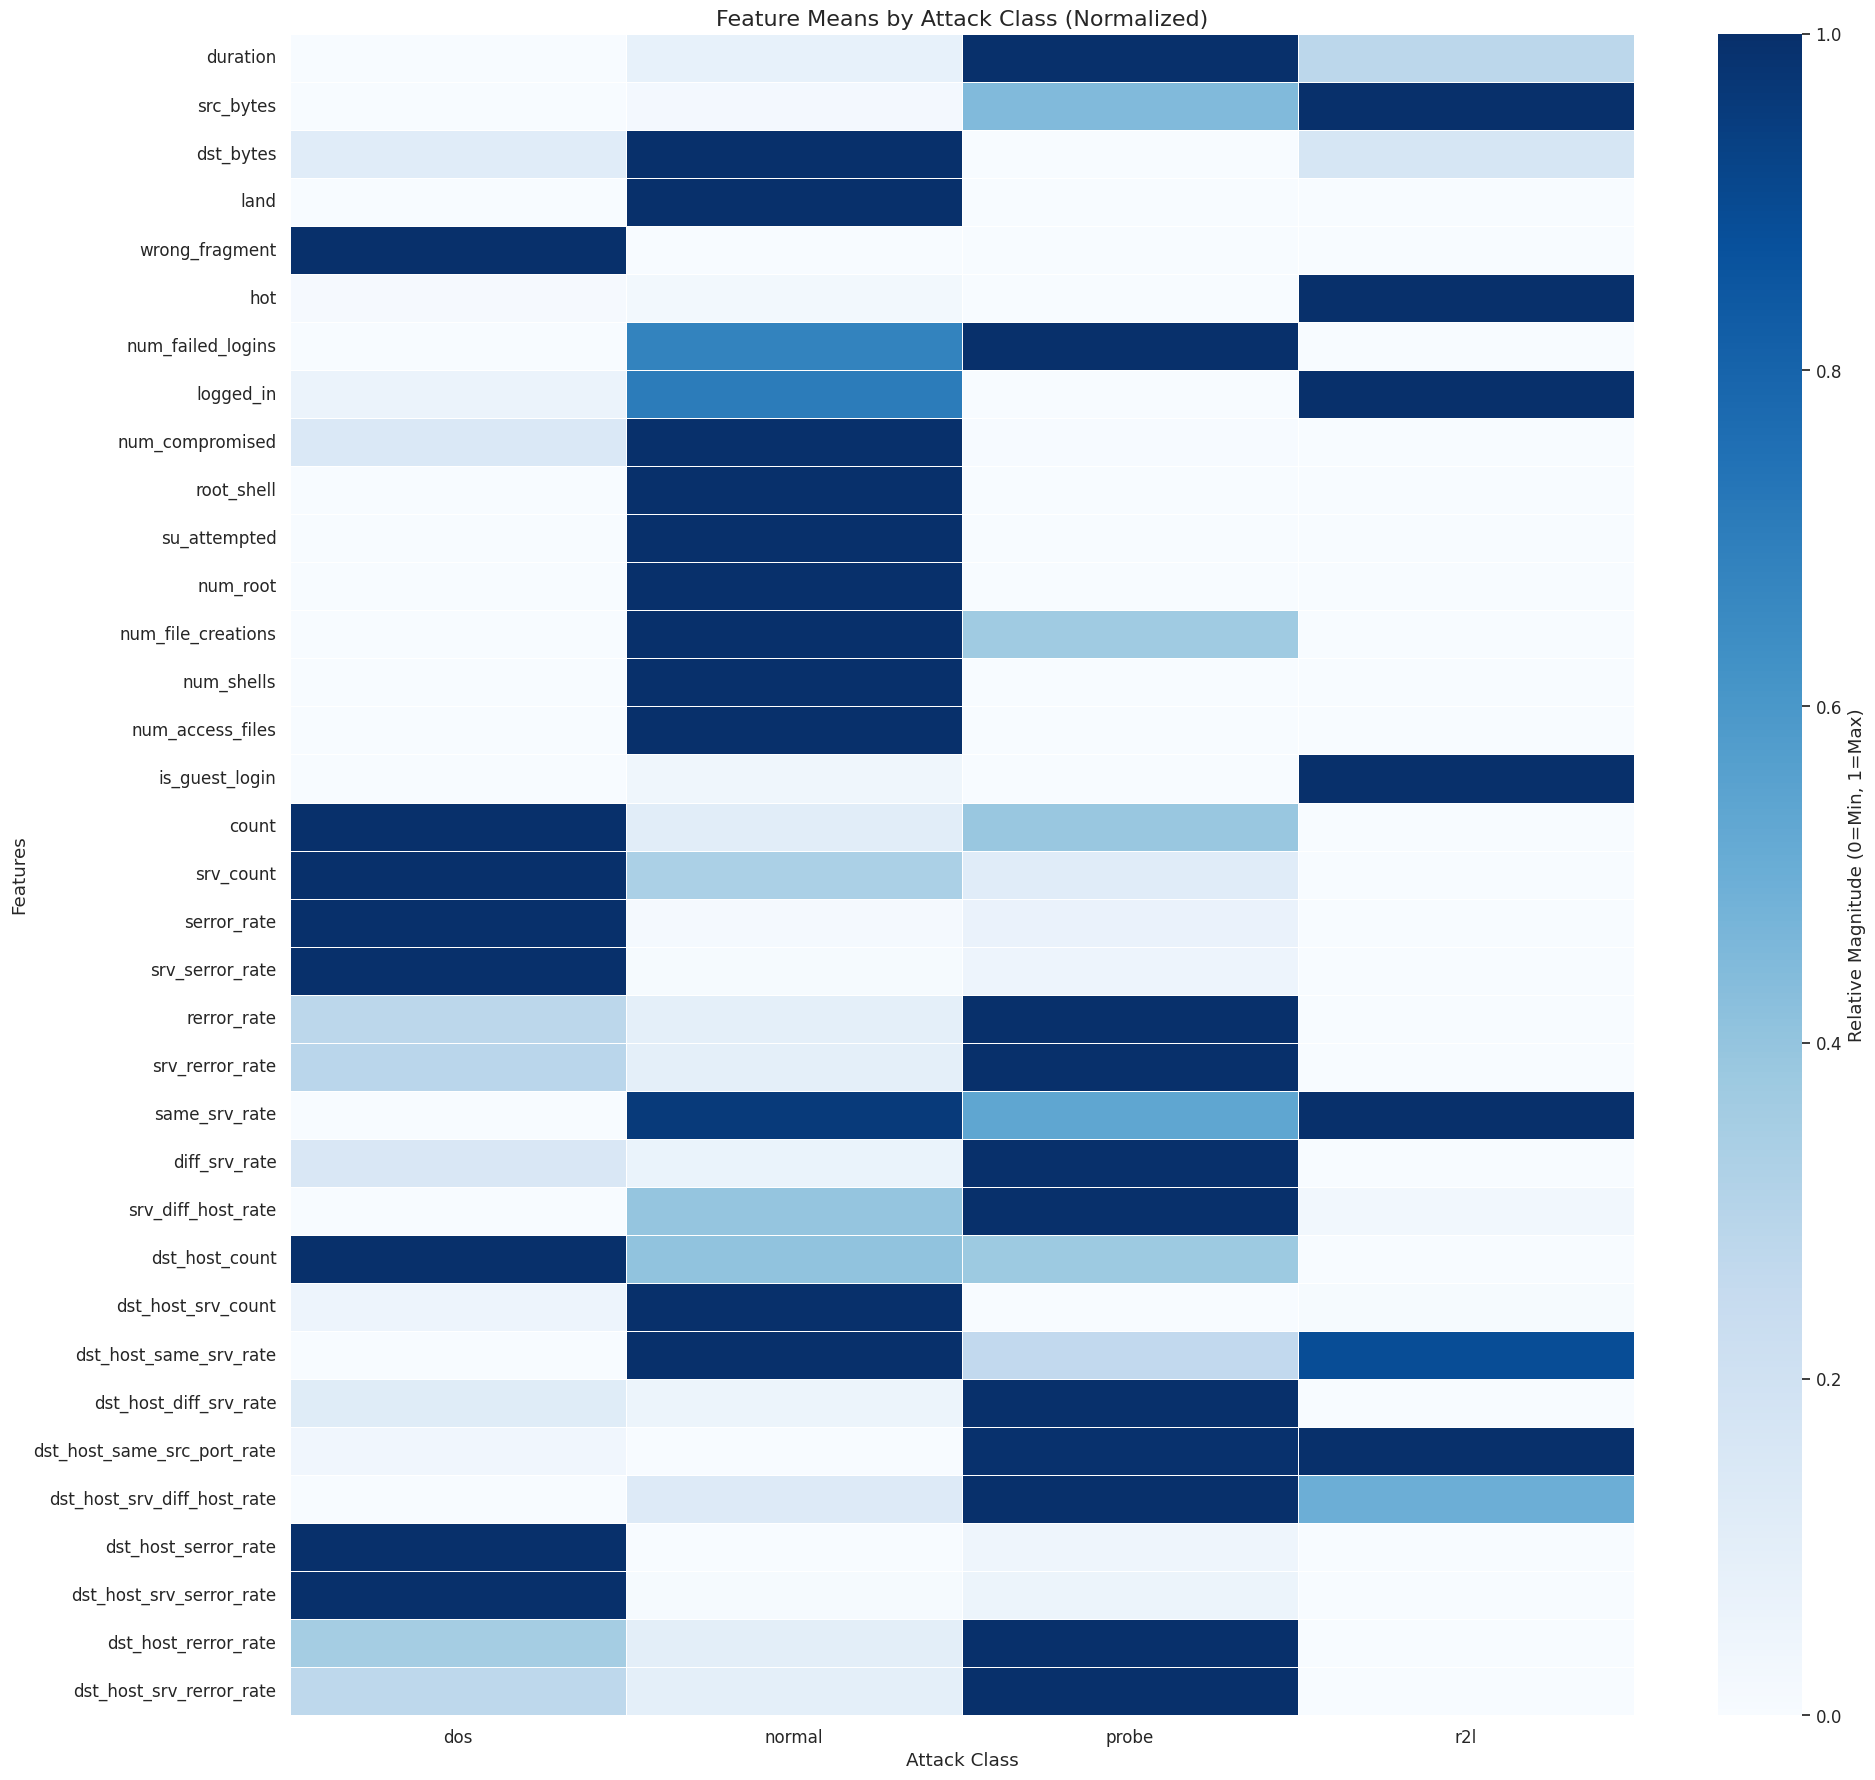

In [33]:
# --- Mean Heatmap ---
print("Generating Mean Heatmap...")
mean_stats = analysis_df.groupby('label').mean()
plot_feature_heatmap(mean_stats, "Feature Means by Attack Class (Normalized)", "task1_mean_heatmap")

Generating Std Dev Heatmap...


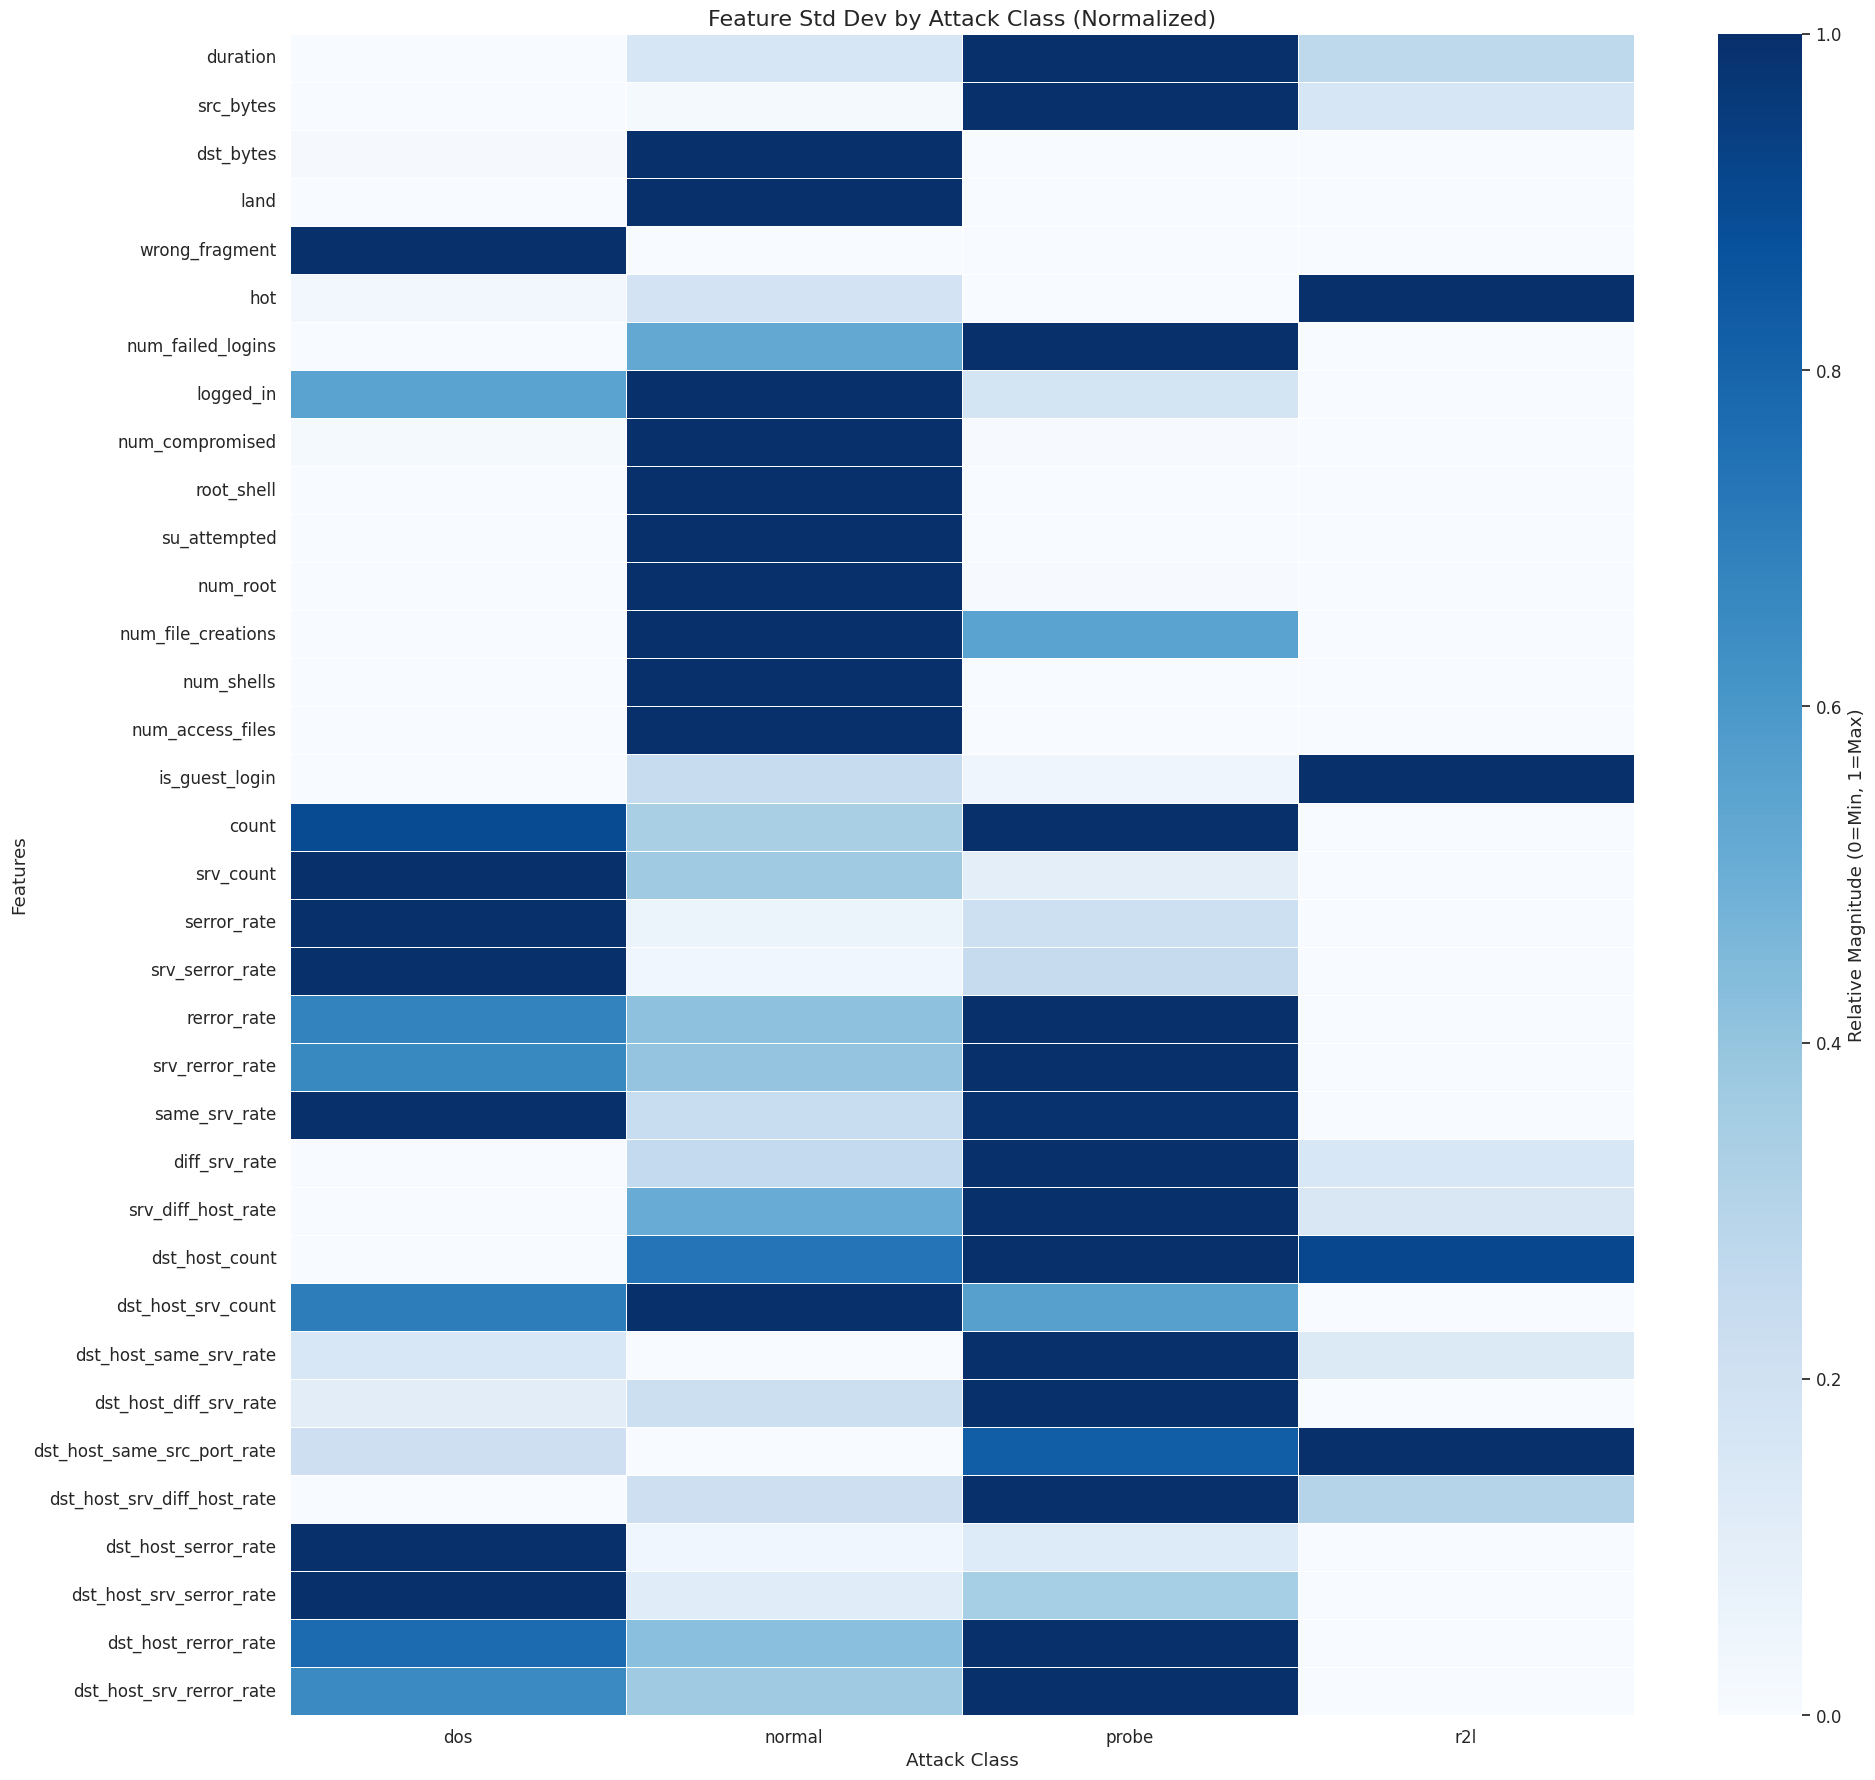

In [34]:
# --- Standard Deviation Heatmap ---
print("Generating Std Dev Heatmap...")
std_stats = analysis_df.groupby('label').std()
plot_feature_heatmap(std_stats, "Feature Std Dev by Attack Class (Normalized)", "task1_std_heatmap")

Generating Median Heatmap...


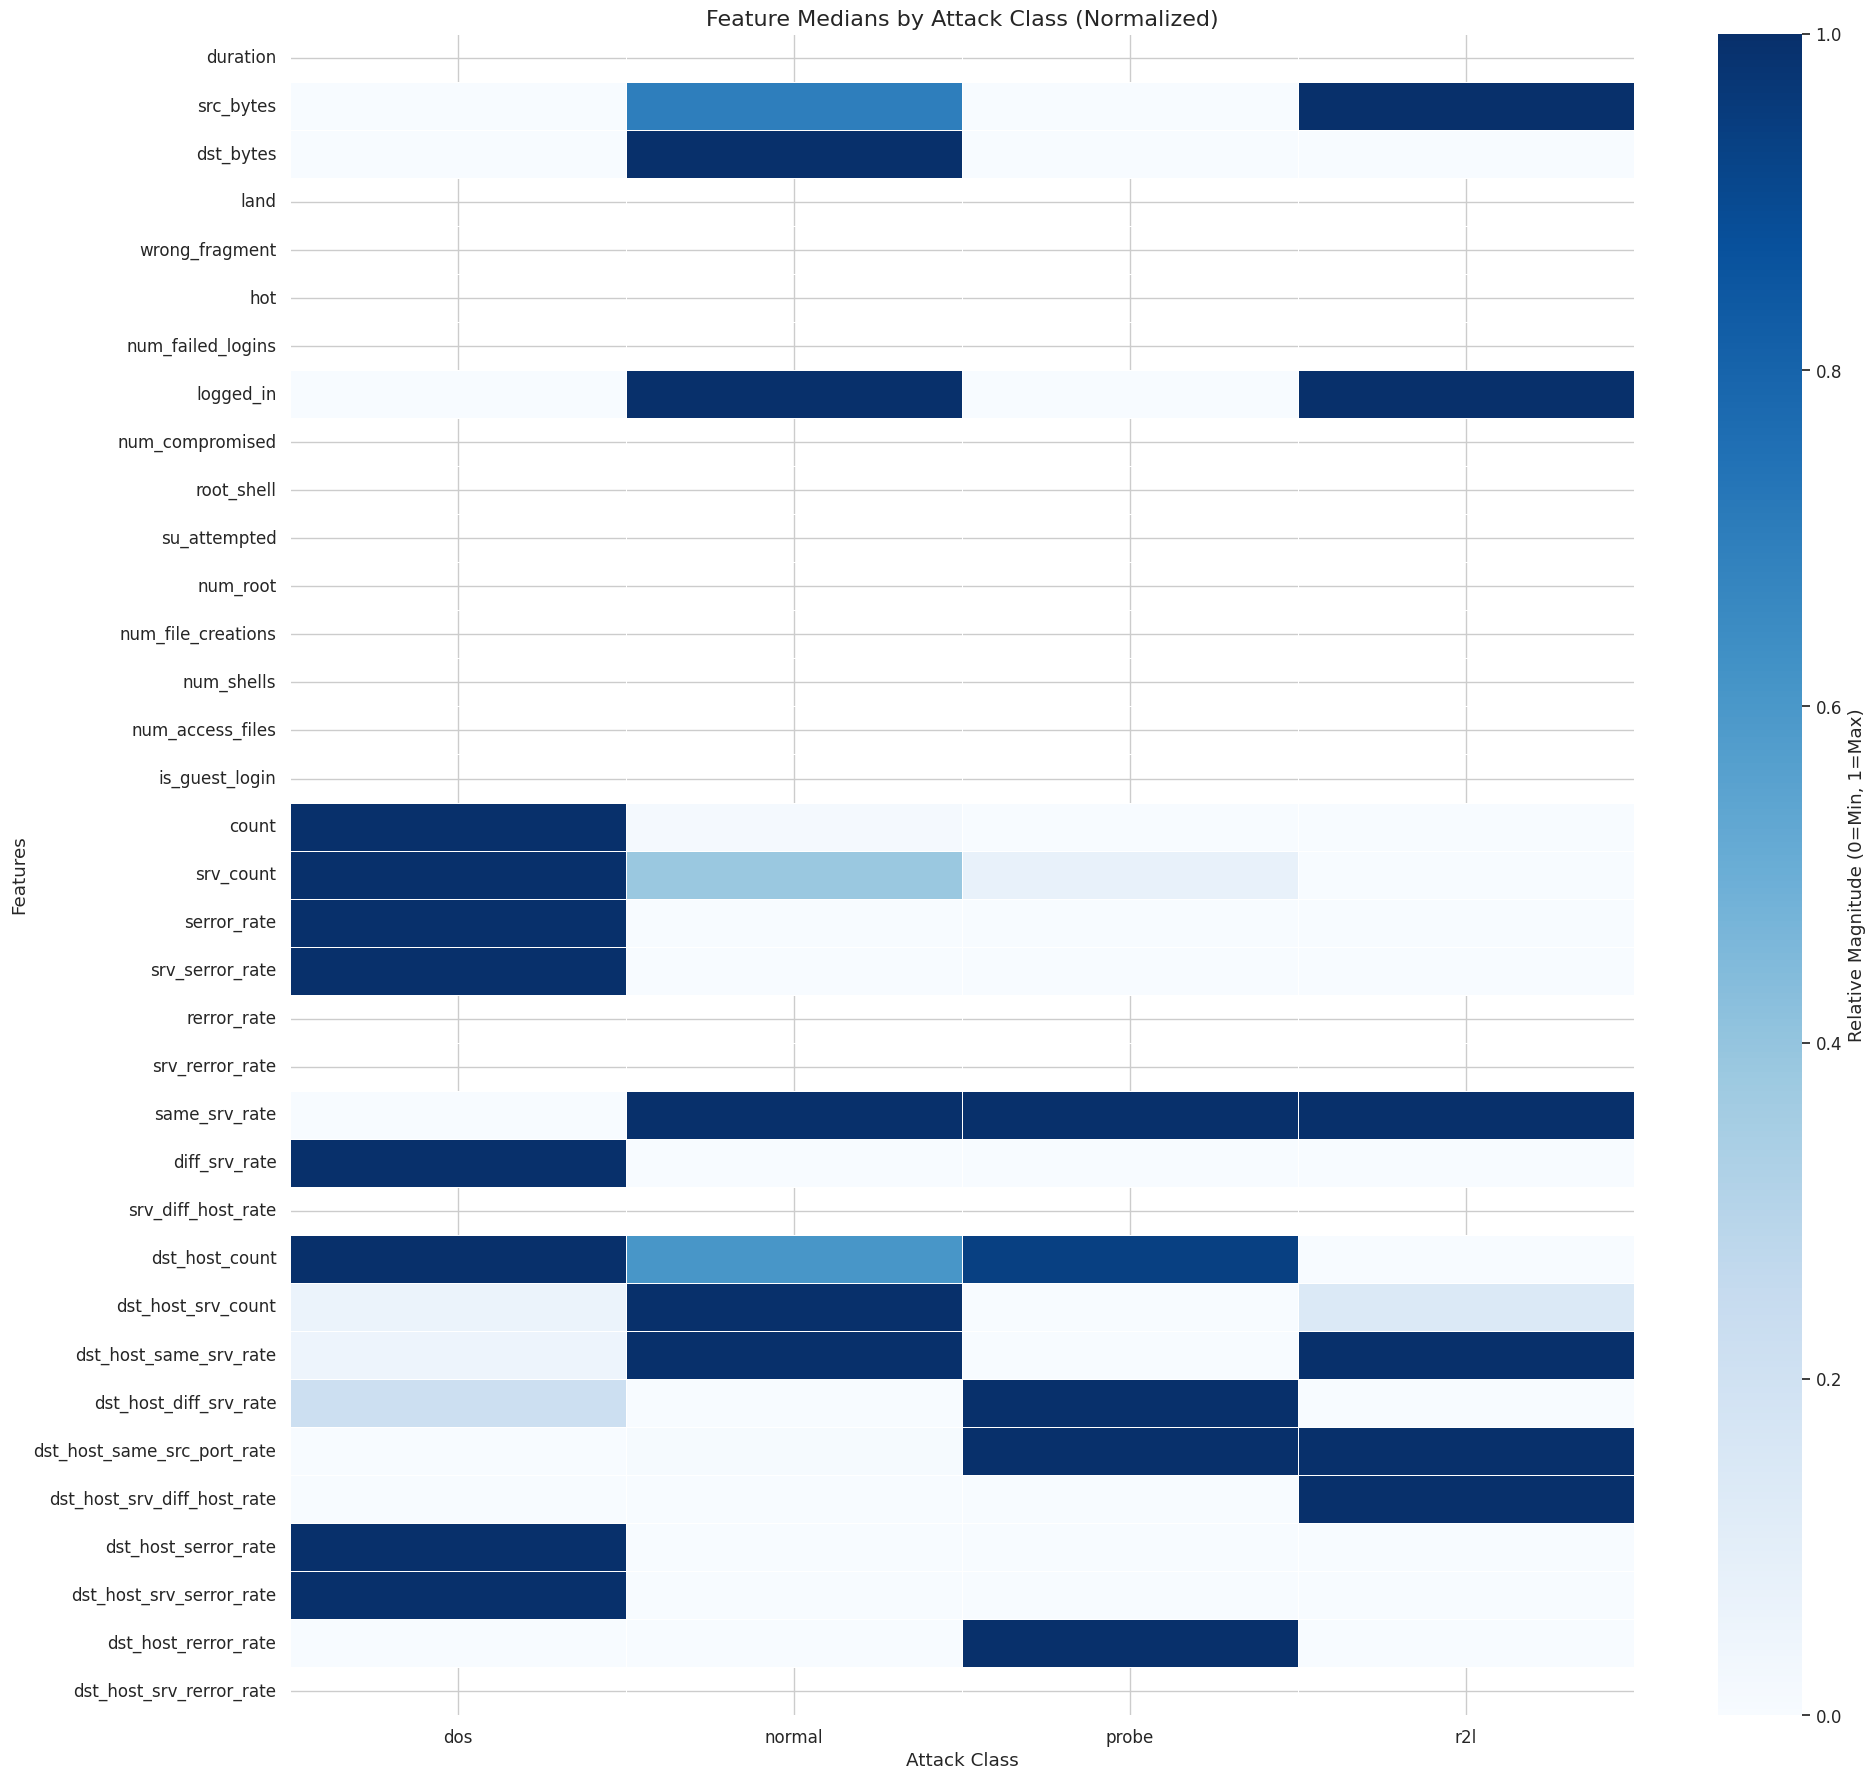

In [35]:
# --- Median Heatmap ---
print("Generating Median Heatmap...")
median_stats = analysis_df.groupby('label').median()
plot_feature_heatmap(median_stats, "Feature Medians by Attack Class (Normalized)", "task1_median_heatmap")

#### Q: Looking at the different heatmaps, do you find any main characteristics that are strongly correlated with a specific attack?

TODO

## Task 2 - Shallow Anomaly Detection - Supervised vs Unsupervised

text

In [36]:
# Create directory for plots
save_dir = results_path + 'images/' + 'task2_plots/'
os.makedirs(save_dir, exist_ok=True)

In [37]:
# Helper function to evaluate and report results
def evaluate_model(model, X, y_true, title="Model Evaluation"):
    """
    Predicts anomalies and prints classification metrics.
    Returns predicted labels and F1 score.
    """
    # Predict: 1 for inliers, -1 for outliers
    y_pred_raw = model.predict(X)

    # Convert: -1 (anomaly) -> 1, 1 (normal) -> 0
    y_pred = np.where(y_pred_raw == -1, 1, 0)

    print(f"\n--- {title} ---")
    print(classification_report(y_true, y_pred, target_names=['Normal', 'Anomaly']))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
    plt.title(f"Confusion Matrix: {title}")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return y_pred, f1_score(y_true, y_pred, average='macro')

### One-Class SVM with Normal data only

First, train a One-Class Support Vector Machine (OC-SVM) with benign (normal) traffic only using an rbf kernel. Then, evaluate the performance using all training data (normal + anomalies).

Normal Training Samples: 10758

Training OC-SVM with nu=0.01 (Estimate)...
Training OC-SVM with nu=0.5 (Default)...

--- OC-SVM (Normal Only) | Validation | nu=0.01 ---
              precision    recall  f1-score   support

      Normal       0.91      0.99      0.94      2689
     Anomaly       0.96      0.74      0.84      1077

    accuracy                           0.92      3766
   macro avg       0.93      0.86      0.89      3766
weighted avg       0.92      0.92      0.91      3766



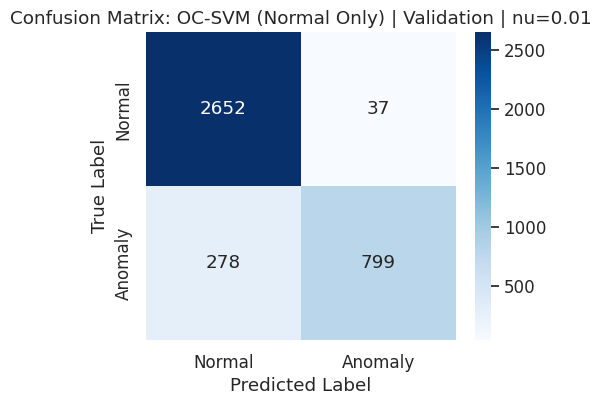


--- OC-SVM (Normal Only) | Validation | nu=0.5 ---
              precision    recall  f1-score   support

      Normal       0.99      0.53      0.69      2689
     Anomaly       0.46      0.99      0.63      1077

    accuracy                           0.66      3766
   macro avg       0.72      0.76      0.66      3766
weighted avg       0.84      0.66      0.67      3766



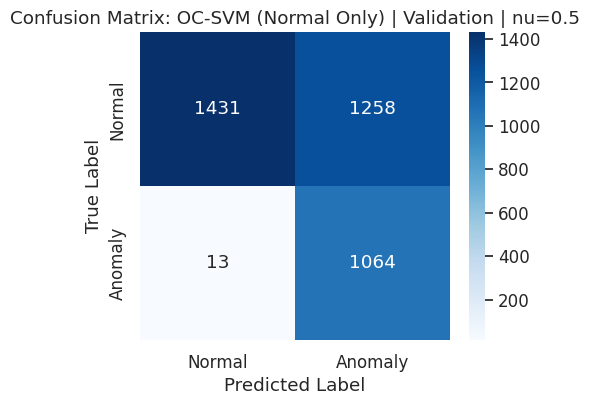


--- OC-SVM (Normal Only) | Test | nu=0.01 ---
              precision    recall  f1-score   support

      Normal       0.64      0.74      0.69      2152
     Anomaly       0.84      0.76      0.79      3674

    accuracy                           0.75      5826
   macro avg       0.74      0.75      0.74      5826
weighted avg       0.76      0.75      0.76      5826



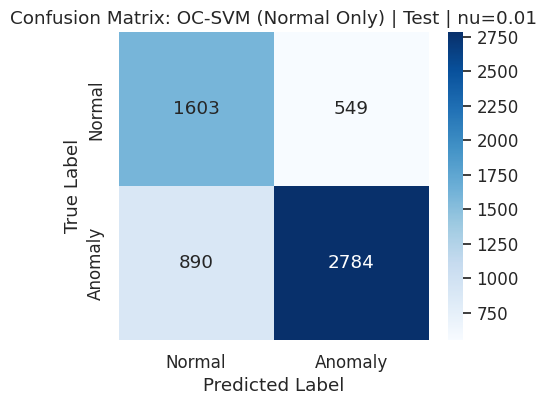


--- OC-SVM (Normal Only) | Test | nu=0.5 ---
              precision    recall  f1-score   support

      Normal       0.70      0.09      0.15      2152
     Anomaly       0.65      0.98      0.78      3674

    accuracy                           0.65      5826
   macro avg       0.68      0.53      0.47      5826
weighted avg       0.67      0.65      0.55      5826



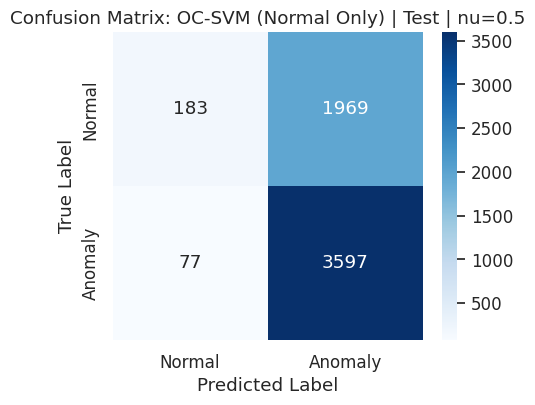

(array([1, 1, 1, ..., 1, 1, 1]), 0.46515636105188346)

In [38]:
# --- OC-SVM on Normal Data Only ---

# 1. Filter Training Data (Normal Only)
X_train_normal = X_train[y_train_binary == 0]

print(f"Normal Training Samples: {X_train_normal.shape[0]}\n")

# 2. Define Estimates for Nu
# Estimate: Since data is 'clean' (normal only), we expect very few outliers.
# We set a low nu (e.g., 0.01) to allow for 1% noise but mostly fit the data tightly.
nu_estimate = 0.01
nu_default = 0.5 # Sklearn default

# 3. Define Models
ocsvm_estimate = OneClassSVM(kernel='rbf', gamma='scale', nu=nu_estimate)
ocsvm_default = OneClassSVM(kernel='rbf', gamma='scale', nu=nu_default)

# 4. Train Models (Fit on Normal Only)
print(f"Training OC-SVM with nu={nu_estimate} (Estimate)...")
ocsvm_estimate.fit(X_train_normal)

print(f"Training OC-SVM with nu={nu_default} (Default)...")
ocsvm_default.fit(X_train_normal)

# 5. Evaluate on Validation Set (which contains anomalies)
evaluate_model(ocsvm_estimate, X_val, y_val_binary, f"OC-SVM (Normal Only) | Validation | nu={nu_estimate}")
evaluate_model(ocsvm_default, X_val, y_val_binary, f"OC-SVM (Normal Only) | Validation | nu={nu_default}")

# 6. Evaluate on Test Set
evaluate_model(ocsvm_estimate, X_test, y_test_binary, f"OC-SVM (Normal Only) | Test | nu={nu_estimate}")
evaluate_model(ocsvm_default, X_test, y_test_binary, f"OC-SVM (Normal Only) | Test | nu={nu_default}")

#### Q: Considering that you are currently training only on normal data, which is a good estimate for the parameter `nu`? What is the impact on training performance? Try both your estimate and the default value of `nu`.

A good estimate for `nu` is a small value, such as **0.01**. Since the training data consists purely of normal traffic, we assume a low contamination rate (1% noise). This allows for a tight boundary around normal behavior. The default value of `nu=0.5` is unsuitable because it forces the model to treat 50% of the valid normal data as outliers, resulting in a massive false positive rate and poor anomaly detection.

### One-Class SVM with All data

Now train the OC-SVM with both normal and anomalous data. Estimate nu as the ratio of anomalous data across the entire collection. Then, evaluate the performance.

Total Samples: 15064, Anomalies: 4306
Estimated Contamination (Nu): 0.2858

Training OC-SVM with nu=0.2858 on ALL data...

--- OC-SVM (All Data) | Validation | nu=0.2858 ---
              precision    recall  f1-score   support

      Normal       0.85      0.86      0.85      2689
     Anomaly       0.64      0.61      0.62      1077

    accuracy                           0.79      3766
   macro avg       0.74      0.74      0.74      3766
weighted avg       0.79      0.79      0.79      3766



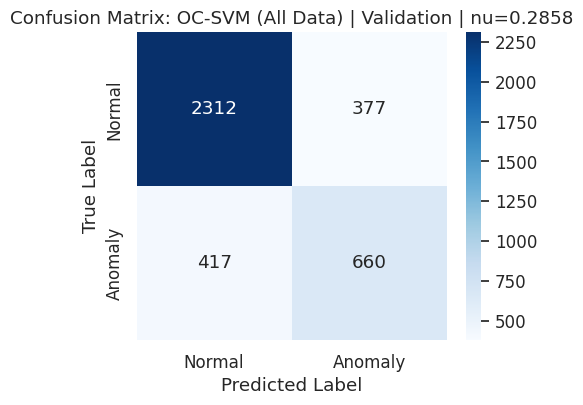


--- OC-SVM (All Data) | Test | nu=0.2858 ---
              precision    recall  f1-score   support

      Normal       0.54      0.60      0.57      2152
     Anomaly       0.75      0.70      0.72      3674

    accuracy                           0.66      5826
   macro avg       0.65      0.65      0.65      5826
weighted avg       0.67      0.66      0.67      5826



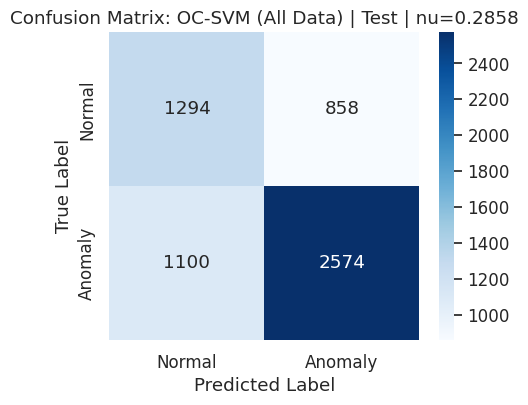

(array([1, 1, 1, ..., 0, 1, 1]), 0.6468749446660829)

In [39]:
# --- OC-SVM on All Training Data ---

# 1. Estimate Nu as the ratio of anomalies in the entire training set
# nu is essentially the "Upper bound on the fraction of training errors" and "Lower bound of the fraction of support vectors"
n_samples = len(y_train_binary)
n_anomalies = y_train_binary.sum() # Sum of 1s
contamination_rate = n_anomalies / n_samples

print(f"Total Samples: {n_samples}, Anomalies: {n_anomalies}")
print(f"Estimated Contamination (Nu): {contamination_rate:.4f}")

# 2. Train Model
print(f"\nTraining OC-SVM with nu={contamination_rate:.4f} on ALL data...")
ocsvm_all = OneClassSVM(kernel='rbf', gamma='scale', nu=contamination_rate)
ocsvm_all.fit(X_train)

# 3. Evaluate on Full Training Data
evaluate_model(ocsvm_all, X_val, y_val_binary, f"OC-SVM (All Data) | Validation | nu={contamination_rate:.4f}")
evaluate_model(ocsvm_all, X_test, y_test_binary, f"OC-SVM (All Data) | Test | nu={contamination_rate:.4f}")

#### Q: Which model performs better? Why do you think that?

The **OC-SVM model trained on Normal Data Only** (with `nu=0.01`) performs significantly better on the validation set, achieving a Macro-F1 score of **0.89**. In contrast, the **OC-SVM model trained on All Data** (with `nu=0.2858`) only achieved a Macro-F1 score of **0.74** on the validation set.

This difference in performance is expected because One-Class SVM is fundamentally designed to define a boundary around a single, 'normal' class. When the model is trained exclusively on normal data, it learns a more precise and accurate representation of what constitutes normal behavior. The presence of anomalous data during training, even if the `nu` parameter is adjusted to reflect the contamination rate, can cause the model's decision boundary to shift. These anomalies pull the boundary away from the true distribution of normal data in the high-dimensional feature space, making it harder for the model to effectively separate new normal instances from actual anomalies, thereby reducing its overall performance.

### One-Class SVM with normal traffic and some anomalies

Evaluate the impact of the percentage of anomalies while training. Train several OC-SVMs with an increasing subsample of anomalous classes (10%, 20%, 50%, 100% of anomalies). Estimate the nu parameter for each scenario.

Evaluating impact of anomaly contamination...
Training with 0% of available anomalies (0 samples). Nu: 0.0010

--- Mix 0% Anomalies ---
              precision    recall  f1-score   support

      Normal       0.91      0.99      0.95      2689
     Anomaly       0.96      0.75      0.84      1077

    accuracy                           0.92      3766
   macro avg       0.93      0.87      0.89      3766
weighted avg       0.92      0.92      0.92      3766



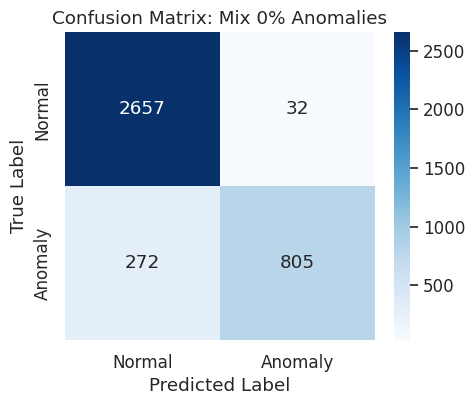

Training with 10% of available anomalies (430 samples). Nu: 0.0384

--- Mix 10% Anomalies ---
              precision    recall  f1-score   support

      Normal       0.77      0.97      0.86      2689
     Anomaly       0.82      0.29      0.43      1077

    accuracy                           0.78      3766
   macro avg       0.80      0.63      0.65      3766
weighted avg       0.79      0.78      0.74      3766



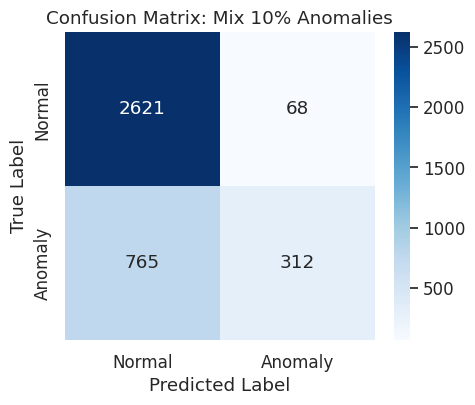

Training with 20% of available anomalies (861 samples). Nu: 0.0741

--- Mix 20% Anomalies ---
              precision    recall  f1-score   support

      Normal       0.78      0.96      0.86      2689
     Anomaly       0.76      0.35      0.48      1077

    accuracy                           0.78      3766
   macro avg       0.77      0.65      0.67      3766
weighted avg       0.78      0.78      0.75      3766



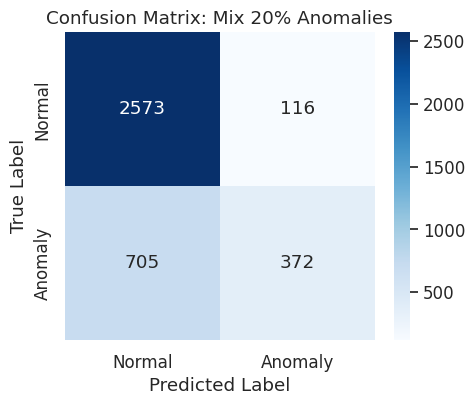

Training with 50% of available anomalies (2153 samples). Nu: 0.1668

--- Mix 50% Anomalies ---
              precision    recall  f1-score   support

      Normal       0.82      0.92      0.87      2689
     Anomaly       0.71      0.50      0.59      1077

    accuracy                           0.80      3766
   macro avg       0.76      0.71      0.73      3766
weighted avg       0.79      0.80      0.79      3766



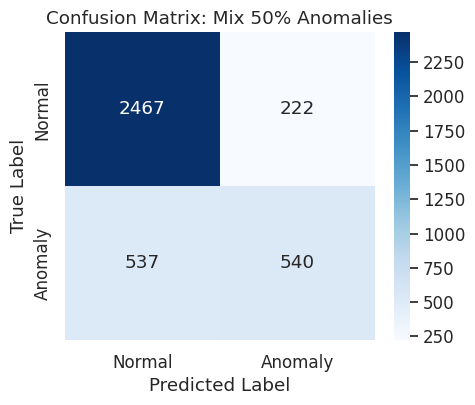

Training with 100% of available anomalies (4306 samples). Nu: 0.2858

--- Mix 100% Anomalies ---
              precision    recall  f1-score   support

      Normal       0.85      0.86      0.85      2689
     Anomaly       0.64      0.61      0.62      1077

    accuracy                           0.79      3766
   macro avg       0.74      0.74      0.74      3766
weighted avg       0.79      0.79      0.79      3766



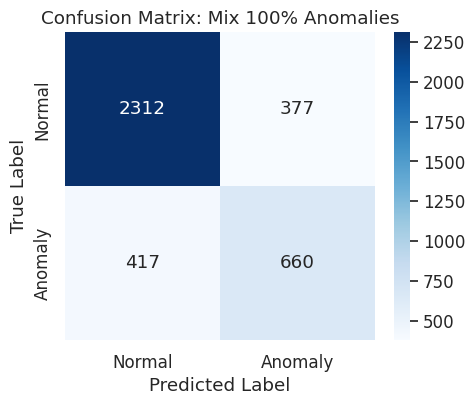

In [40]:
# --- Sensitivity Analysis (Anomaly Ratios) ---

# 1. Separate Normal and Anomalous Data
X_train_normal = X_train[y_train_binary == 0]
X_train_anom = X_train[y_train_binary == 1]

# Ratios to test (Percentage of total available anomalies to verify)
anomaly_percentages = [0.0, 0.1, 0.2, 0.5, 1.0]
f1_scores = []

# Store models for robustness check later
models_sensitivity = {}

print("Evaluating impact of anomaly contamination...")

for p in anomaly_percentages:
    # 1. Sample anomalies
    if p == 0:
        X_sample_anom = np.empty((0, X_train_normal.shape[1])) # Empty array with same columns
    else:
        # Select p% of the available anomalies
        n_total_anomalies = X_train_anom.shape[0]
        sample_size = int(n_total_anomalies * p)

        # Ensure sample_size is at least 1 if p > 0 and there are anomalies to sample
        # If n_total_anomalies is 0, sample_size will be 0, which is fine.
        if sample_size == 0 and p > 0 and n_total_anomalies > 0:
            sample_size = 1 # Sample at least one anomaly if supposed to

        if sample_size > 0:
            # Use np.random.choice to select indices, then select rows
            np.random.seed(42) # For reproducibility of sampling
            sampled_indices = np.random.choice(n_total_anomalies, size=sample_size, replace=False)
            X_sample_anom = X_train_anom[sampled_indices]
        else:
            X_sample_anom = np.empty((0, X_train_normal.shape[1]))

    # 2. Prepare Mixed Training Data
    if X_sample_anom.shape[0] > 0:
        # Concatenate Normal + Sampled Anomalies
        X_train_mixed = np.vstack([X_train_normal, X_sample_anom])

        # Calculate nu based on the specific mix contamination
        current_nu = X_sample_anom.shape[0] / X_train_mixed.shape[0]

        # Bounds check for nu
        if current_nu <= 0: current_nu = 0.001
        if current_nu > 1: current_nu = 0.99
    else:
        # Pure Normal data
        X_train_mixed = X_train_normal
        current_nu = 0.001 # Fallback small nu for pure normal

    print(f"Training with {int(p*100)}% of available anomalies ({X_sample_anom.shape[0]} samples). Nu: {current_nu:.4f}")

    # 3. Train Model
    ocsvm_mixed = OneClassSVM(kernel='rbf', gamma='scale', nu=current_nu)
    ocsvm_mixed.fit(X_train_mixed)

    # Store model for later use
    models_sensitivity[p] = ocsvm_mixed

    # 4. Evaluate on Validation Set
    _, f1_val = evaluate_model(ocsvm_mixed, X_val, y_val_binary, title=f"Mix {int(p*100)}% Anomalies")
    f1_scores.append(f1_val)

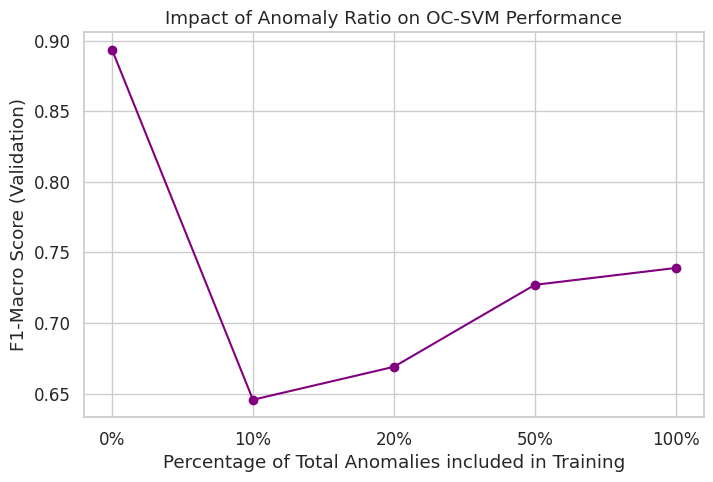

In [41]:
# Plotting the results
plt.figure(figsize=(8, 5))
plt.plot([f"{int(p*100)}%" for p in anomaly_percentages], f1_scores, marker='o', linestyle='-', color='purple')
plt.xlabel("Percentage of Total Anomalies included in Training")
plt.ylabel("F1-Macro Score (Validation)")
plt.title("Impact of Anomaly Ratio on OC-SVM Performance")
plt.grid(True)
plt.show()

#### Q: Plot the f1-macro score for each scenario. How does the increasing ratio of anomalies affect the results?

Based on the results, the **F1-Macro Score** follows a "Dip and Recover" trend as the anomaly ratio increases:

- **0% Anomalies (Best Performance)**: The model works best as a **Novelty Detector** (trained on clean data with small `nu`). It creates a tight boundary around normal data, achieving the highest F1 score (**0.89**).

- **10-20% Anomalies (Performance Drop)**: Performance suffers significantly (**0.65-0.67**). The model struggles to distinguish minority anomalies from normal data, accepting them as normal and leading to high **False Negatives**.

- **50-100% Anomalies (Partial Recovery)**: Performance improves (**~0.74**) but doesn't beat the baseline. A higher `nu` forces the model to act as an **Outlier Detector**, rejecting a large portion of data. This catches more anomalies but misclassifies more normal traffic (lower Precision).

**Conclusion**: This dataset is best modeled using **Novelty Detection** (0% contamination).

The trend proves that **small amounts of contamination are more dangerous to the model than large amounts**.

- **Small contamination**: Corrupts the boundary (Worst performance).

- **Large contamination**: Forces the boundary to shrink to the core (Better performance, but less precise).


### Robustness of the One-Class SVM model

Finally, use the test set to assess the robustness. Use models trained with:
1. Only normal data
2. All data
3. 10% of anomalous data

Robustness Check on Test Set

>>> Evaluating: Normal Only (p=0.0)
              precision    recall  f1-score   support

      Normal     0.6425    0.7458    0.6903      2152
     Anomaly     0.8356    0.7569    0.7943      3674

    accuracy                         0.7528      5826
   macro avg     0.7391    0.7514    0.7423      5826
weighted avg     0.7643    0.7528    0.7559      5826

Confusion Summary:
 - True Normals caught:      1605
 - Normal seen as Anomaly:   547 (False Positive)
 - Anomalies caught:         2781
 - Anomalies missed:         893 (False Negative)

Most Confused Attacks (Missed Anomalies):
label
dos      782
probe    111
Name: count, dtype: int64


/tmp/ipython-input-2599494234.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missed_counts.index[:10], y=missed_counts.values[:10], palette="Reds_r")


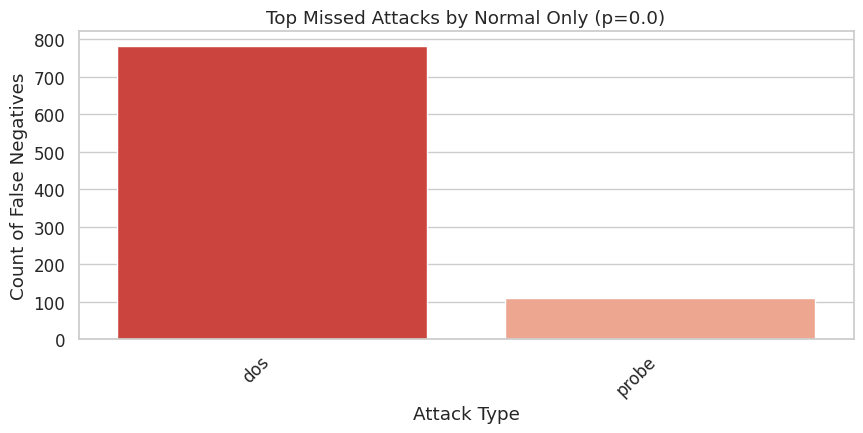


>>> Evaluating: All Data (p=1.0)
              precision    recall  f1-score   support

      Normal     0.5405    0.6013    0.5693      2152
     Anomaly     0.7500    0.7006    0.7245      3674

    accuracy                         0.6639      5826
   macro avg     0.6453    0.6509    0.6469      5826
weighted avg     0.6726    0.6639    0.6671      5826

Confusion Summary:
 - True Normals caught:      1294
 - Normal seen as Anomaly:   858 (False Positive)
 - Anomalies caught:         2574
 - Anomalies missed:         1100 (False Negative)

Most Confused Attacks (Missed Anomalies):
label
dos      1083
probe      17
Name: count, dtype: int64


/tmp/ipython-input-2599494234.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missed_counts.index[:10], y=missed_counts.values[:10], palette="Reds_r")


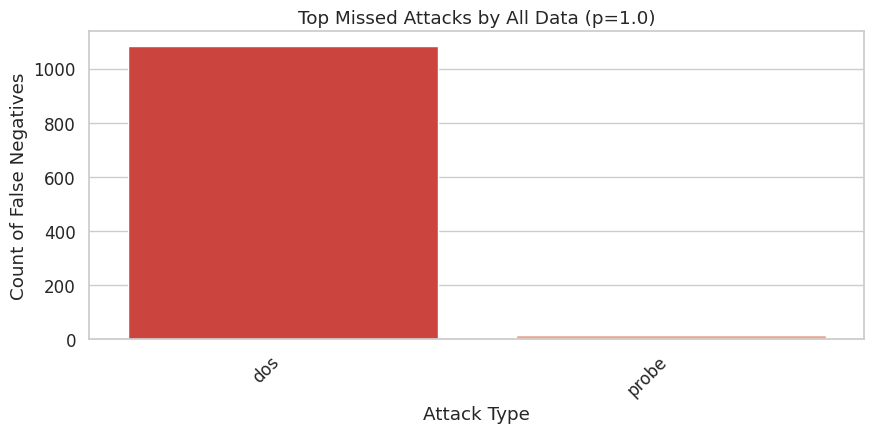


>>> Evaluating: 10% Anomalies (p=0.1)
              precision    recall  f1-score   support

      Normal     0.3984    0.7328    0.5162      2152
     Anomaly     0.6922    0.3519    0.4666      3674

    accuracy                         0.4926      5826
   macro avg     0.5453    0.5424    0.4914      5826
weighted avg     0.5837    0.4926    0.4849      5826

Confusion Summary:
 - True Normals caught:      1577
 - Normal seen as Anomaly:   575 (False Positive)
 - Anomalies caught:         1293
 - Anomalies missed:         2381 (False Negative)

Most Confused Attacks (Missed Anomalies):
label
dos      2021
probe     360
Name: count, dtype: int64


/tmp/ipython-input-2599494234.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missed_counts.index[:10], y=missed_counts.values[:10], palette="Reds_r")


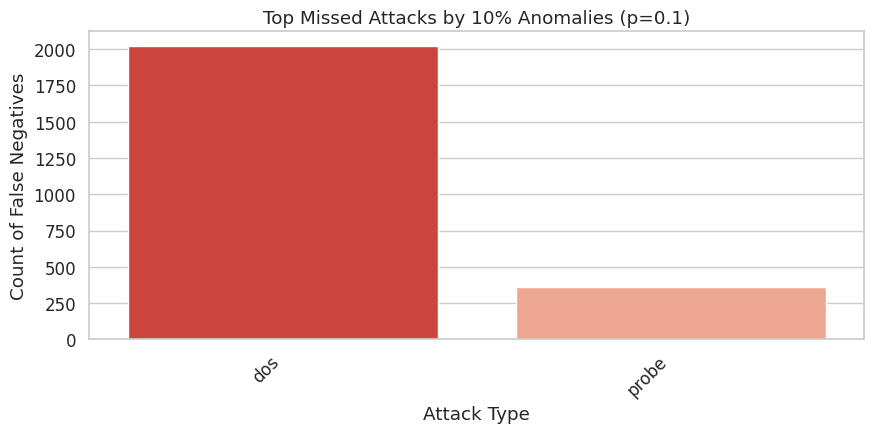

In [43]:
print("Robustness Check on Test Set")

# We compare 3 models:
# 1. Trained on Normal Only (corresponds to p=0.0 in our sensitivity dictionary)
# 2. Trained on All Data (corresponds to p=1.0)
# 3. Trained on 10% Anomalies (corresponds to p=0.1)

scenarios = [
    ("Normal Only (p=0.0)", 0.0),
    ("All Data (p=1.0)", 1.0),
    ("10% Anomalies (p=0.1)", 0.1)
]

for name, p_key in scenarios:
    if p_key not in models_sensitivity:
        print(f"Skipping {name}: Model not found in models_sensitivity dictionary.")
        continue

    model = models_sensitivity[p_key]
    print(f"\n>>> Evaluating: {name}")

    # 1. Predict on Test Set
    # OCSVM: 1 = Normal, -1 = Anomaly
    y_pred_raw = model.predict(X_test)

    # Convert to: 0 = Normal, 1 = Anomaly
    y_pred = np.where(y_pred_raw == -1, 1, 0)

    # 2. Classification Report
    print(classification_report(y_test_binary, y_pred, target_names=['Normal', 'Anomaly'], digits=4))

    # 3. Confusion Matrix
    cm = confusion_matrix(y_test_binary, y_pred)

    # 4. Attack Confusion Analysis (Which anomalies were missed?)
    # False Negatives: True is Anomaly (1), Predicted is Normal (0)
    mask_missed = (y_test_binary == 1) & (y_pred == 0)
    missed_count = np.sum(mask_missed)

    print(f"Confusion Summary:")
    print(f" - True Normals caught:      {cm[0,0]}")
    print(f" - Normal seen as Anomaly:   {cm[0,1]} (False Positive)")
    print(f" - Anomalies caught:         {cm[1,1]}")
    print(f" - Anomalies missed:         {cm[1,0]} (False Negative)")

    if missed_count > 0:
        # Get the specific attack labels for the missed anomalies
        missed_attacks = y_test_attack[mask_missed]

        # Count frequency of each missed attack type
        missed_counts = pd.Series(missed_attacks).value_counts()

        print("\nMost Confused Attacks (Missed Anomalies):")
        print(missed_counts.head(5))

        # Optional: Plot the missed attacks
        plt.figure(figsize=(10, 4))
        sns.barplot(x=missed_counts.index[:10], y=missed_counts.values[:10], palette="Reds_r")
        plt.title(f"Top Missed Attacks by {name}")
        plt.xlabel("Attack Type")
        plt.ylabel("Count of False Negatives")
        plt.xticks(rotation=45, ha='right')
        plt.show()
    else:
        print("\nNo anomalies were missed! (Perfect Recall)")

#### Q: Is the best-performing model in the training set also the best here?

**Yes.**

- In your previous task (Task 2.3), the **Normal Only (p=0.0)** model had the highest validation score (~0.89 F1-macro).

- In the test set results above, the **Normal Only** model is again the best performer with an **Accuracy of 0.75** and **F1-macro of 0.74**.

- The "All Data" model dropped to ~0.66 accuracy, and the "10% Anomalies" model performed poorly at ~0.49 accuracy. This confirms that the **Novelty Detection** approach (training on clean normal data) generalizes best for this dataset.

#### Q: Does it confuse normal data with anomalies?

**Yes, but it confuses anomalies as normal more often.**

Looking at the Normal Only model's confusion summary:

- **False Positives** (Normal → Anomaly): 547 samples. This means roughly **25%** of normal test data was incorrectly flagged as an anomaly (Recall for Normal is ~0.75).

- **False Negatives** (Anomaly → Normal): 893 samples. This is the higher source of error, meaning the model failed to catch about **24%** of the anomalies (Recall for Anomaly is ~0.76).

#### Q: Which attack is the most confused?

**DoS (Denial of Service).**

- According to the "Most Confused Attacks" breakdown for the best model (Normal Only), the count of missed anomalies (False Negatives) is:

  - **DoS**: 782 missed
  - **Probe**: 111 missed

- While DoS attacks are usually volumetrically distinct, the high number of misses suggests either that `DoS` is the majority anomaly class in the test set (so the absolute error count is higher) or that the specific DoS attacks in the test set mimic normal traffic features (e.g., "slow" DoS attacks) enough to fall inside the learned decision boundary.


## Task 3 - Deep Anomaly Detection and Data Representation

text

In [ ]:
# Create directory for plots
save_dir = results_path + 'images/' + 'task3_plots/'
os.makedirs(save_dir, exist_ok=True)

### Training and Validating Autoencoder with Normal data only

Create an Autoencoder with a shrinking encoder and an expansion decoder. Use normal data only; split into training and validation sets.

In [ ]:
# --- Task 3.1: Autoencoder Architecture & Setup ---

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 1. Prepare Data for PyTorch
# We need to convert Pandas DataFrames to PyTorch FloatTensors
# Note: We train ONLY on Normal data, but we validate on the Validation set (which has mixed data)
# to see if the loss divergence helps us.

# Filter X_train for normal data only
X_train_normal = X_train[y_train_binary == 0].values
X_val_np = X_val.values

# Convert to Tensors, ensuring float type
tensor_train_normal = torch.FloatTensor(X_train_normal.astype(float))
tensor_val = torch.FloatTensor(X_val_np.astype(float))

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(TensorDataset(tensor_train_normal, tensor_train_normal), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(tensor_val, tensor_val), batch_size=batch_size, shuffle=False)

# 2. Define Autoencoder Class
class AutoEncoder(nn.Module):
    def __init__(self, input_dim):
        super(AutoEncoder, self).__init__()

        # Encoder (Shrinking)
        # 114 -> 64 -> 32 (Bottleneck)
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 32), # Bottleneck
            nn.Tanh()
        )

        # Decoder (Expansion)
        # 32 -> 64 -> 114
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.Tanh(),
            nn.Linear(64, input_dim)
            # No activation at the end because inputs are StandardScaler (unbounded), not 0-1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize Model
input_dim = X_train.shape[1] # 114
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoEncoder(input_dim).to(device)

print(f"Model Architecture:\n{model}")
print(f"Training on device: {device}")

Model Architecture:
AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=114, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=114, bias=True)
  )
)
Training on device: cuda


Starting Training...
Epoch [10/50], Train Loss: 0.0547, Val Loss: 0.1197
Epoch [20/50], Train Loss: 0.0319, Val Loss: 0.1102
Epoch [30/50], Train Loss: 0.0213, Val Loss: 0.1148
Epoch [40/50], Train Loss: 0.0160, Val Loss: 0.1181
Epoch [50/50], Train Loss: 0.0130, Val Loss: 0.1309


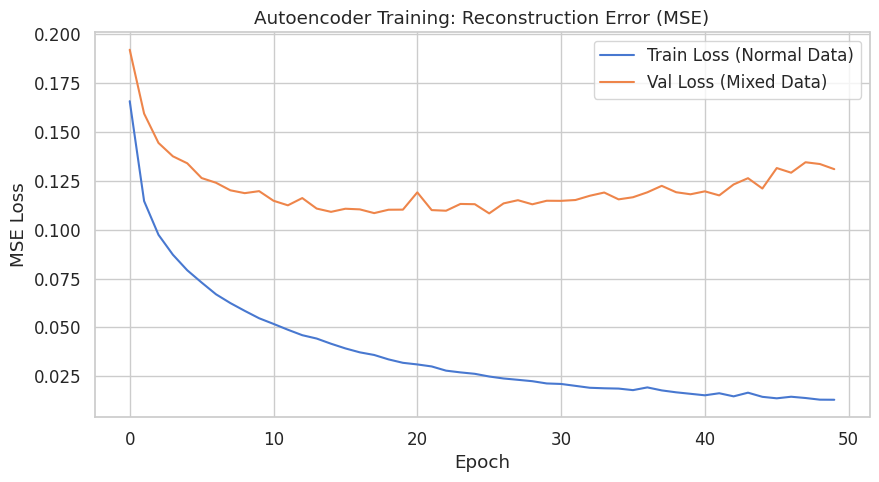

In [ ]:
# --- Task 3.1 (Continued): Training Loop ---

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 50

train_losses = []
val_losses = []

print("Starting Training...")

for epoch in range(epochs):
    # Training Phase
    model.train()
    running_loss = 0.0
    for data in train_loader:
        inputs, _ = data # Autoencoder: Input = Target
        inputs = inputs.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation Phase (Calculate MSE on Validation set)
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs, _ = data
            inputs = inputs.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            val_running_loss += loss.item()

    avg_val_loss = val_running_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# Plot Learning Curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss (Normal Data)')
plt.plot(val_losses, label='Val Loss (Mixed Data)')
plt.title("Autoencoder Training: Reconstruction Error (MSE)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()

### Estimate the Reconstruction Error Threshold

Estimate a threshold using the reconstruction error on the validation set. Plot the ECDF curve.

Estimated Reconstruction Threshold (95th percentile): 0.2226


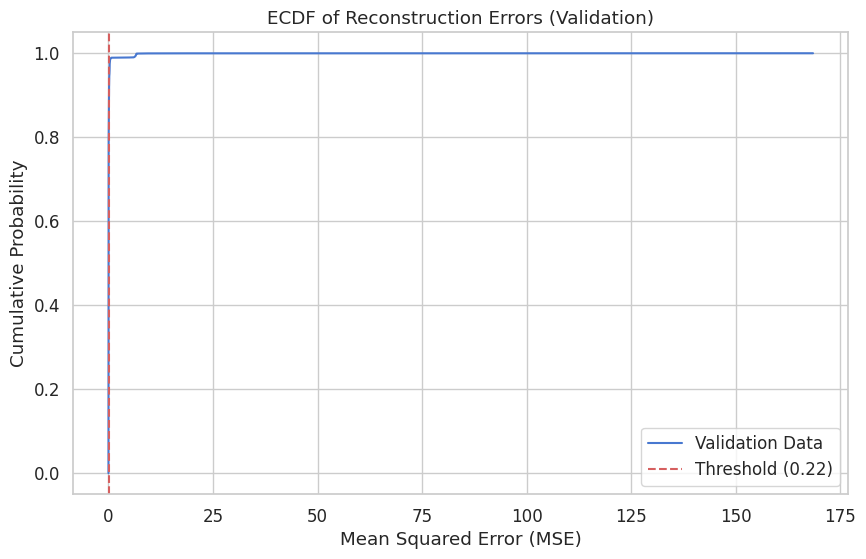

In [ ]:
# --- Task 3.2: Estimate Reconstruction Threshold ---

# Helper to get reconstruction errors for a whole dataset
def get_reconstruction_errors(model, data_tensor):
    model.eval()
    with torch.no_grad():
        data_tensor = data_tensor.to(device)
        reconstructions = model(data_tensor)
        # MSE per sample: Mean over the feature dimension (axis 1)
        mse_per_sample = torch.mean((data_tensor - reconstructions) ** 2, dim=1)
    return mse_per_sample.cpu().numpy()

# 1. Get errors for Validation Set
# Note: We split Val set into Normal and Anomaly just for visualization analysis
val_errors = get_reconstruction_errors(model, tensor_val)

# 2. Define Threshold using Percentile on Validation Data
# Since Val contains anomalies, we shouldn't use Max().
# We assume 90-95% of validation data is normal, so we take the 95th percentile.
threshold = np.percentile(val_errors, 95)

print(f"Estimated Reconstruction Threshold (95th percentile): {threshold:.4f}")

# 3. Plot ECDF (Empirical Cumulative Distribution Function)
def plot_ecdf(data, label):
    sorted_data = np.sort(data)
    yvals = np.arange(len(sorted_data)) / float(len(sorted_data) - 1)
    plt.plot(sorted_data, yvals, label=label)

plt.figure(figsize=(10, 6))
plot_ecdf(val_errors, "Validation Data")
plt.axvline(threshold, color='r', linestyle='--', label=f'Threshold ({threshold:.2f})')
plt.title("ECDF of Reconstruction Errors (Validation)")
plt.xlabel("Mean Squared Error (MSE)")
plt.ylabel("Cumulative Probability")
plt.legend()
plt.grid(True)
plt.show()

#### Q: How did you pick the threshold? What is its value?

TODO

### Anomaly Detection with reconstruction error

Use the trained model and threshold to classify anomalies in the full training set and test set.

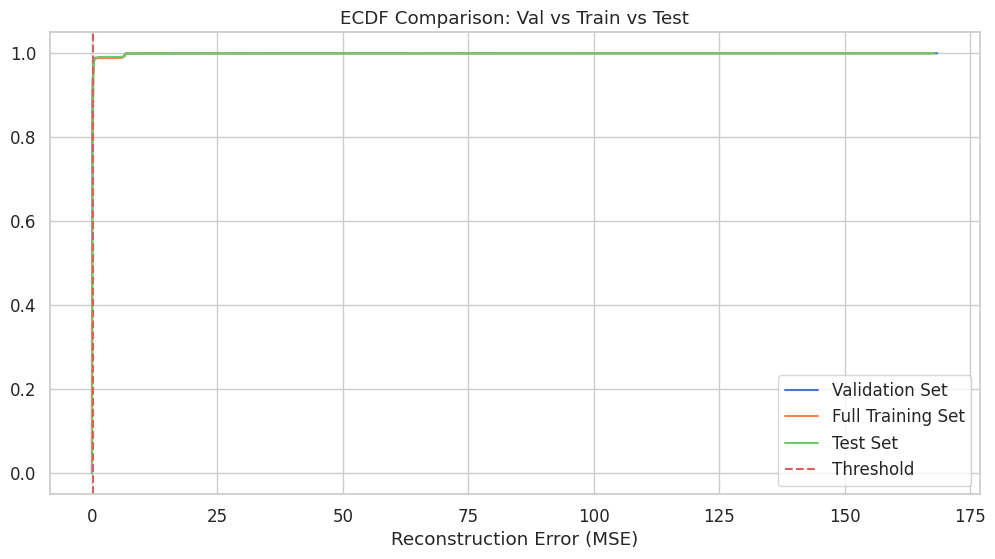


--- Autoencoder Classification Results (Test Set) ---
              precision    recall  f1-score   support

      Normal       0.40      0.96      0.57      2152
     Anomaly       0.87      0.16      0.27      3674

    accuracy                           0.46      5826
   macro avg       0.64      0.56      0.42      5826
weighted avg       0.70      0.46      0.38      5826



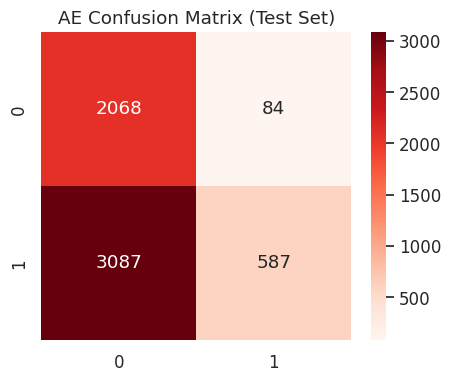

In [ ]:
# --- Task 3.3: Anomaly Detection Evaluation ---

# 1. Compute Errors for Full Train and Test
tensor_train_full = torch.FloatTensor(X_train.values.astype(float))
tensor_test = torch.FloatTensor(X_test.values.astype(float))

train_errors = get_reconstruction_errors(model, tensor_train_full)
test_errors = get_reconstruction_errors(model, tensor_test)

# 2. Plot ECDFs for all sets
plt.figure(figsize=(12, 6))
plot_ecdf(val_errors, "Validation Set")
plot_ecdf(train_errors, "Full Training Set")
plot_ecdf(test_errors, "Test Set")
plt.axvline(threshold, color='r', linestyle='--', label='Threshold')
plt.title("ECDF Comparison: Val vs Train vs Test")
plt.xlabel("Reconstruction Error (MSE)")
plt.legend()
plt.show()

# 3. Classification & Evaluation
# If Error > Threshold -> Anomaly (1)
# If Error <= Threshold -> Normal (0)

y_pred_train = (train_errors > threshold).astype(int)
y_pred_test = (test_errors > threshold).astype(int)

print("\n--- Autoencoder Classification Results (Test Set) ---")
print(classification_report(y_test_binary, y_pred_test, target_names=['Normal', 'Anomaly']))

# Confusion Matrix
cm = confusion_matrix(y_test_binary, y_pred_test)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title("AE Confusion Matrix (Test Set)")
plt.show()

#### Q: Plot and report the ECDF... Why the reconstruction errors higher on the full training set than on the validation one? And why are the reconstruction errors in the test set even higher? How is the performance on the training... and test set?

TODO

### Auto-Encoder's bottleneck and OC-SVM

Use the encoder's bottleneck for data representation. Train an OC-SVM on the bottleneck embeddings of the normal data.

Bottleneck Shape: (9413, 32)
Training OC-SVM on Autoencoder Embeddings...

--- OC-SVM on Latent Space (AE) ---
              precision    recall  f1-score   support

      Normal       0.59      0.78      0.67      2152
     Anomaly       0.84      0.68      0.75      3674

    accuracy                           0.71      5826
   macro avg       0.71      0.73      0.71      5826
weighted avg       0.74      0.71      0.72      5826



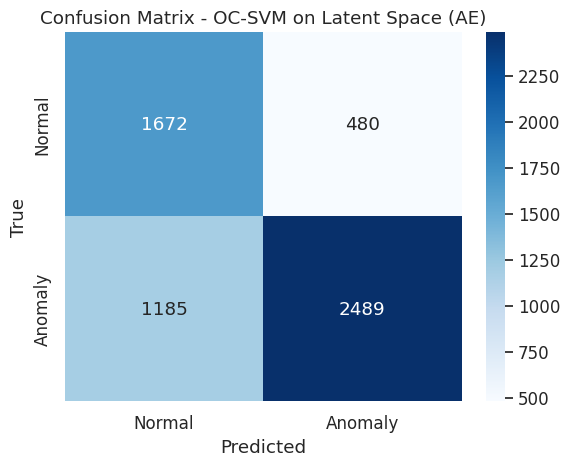

0.708479275915425

In [ ]:
# --- Task 3.4: Bottleneck Embeddings + OC-SVM ---

# 1. Extract Embeddings (Bottleneck)
def get_embeddings(model, data_tensor):
    model.eval()
    with torch.no_grad():
        # We only run the ENCODER part
        embeddings = model.encoder(data_tensor.to(device))
    return embeddings.cpu().numpy()

# Get embeddings for Normal Train Data (to train OC-SVM)
# and Full Test Data (to evaluate)
embeddings_train_normal = get_embeddings(model, tensor_train_normal) # Defined in Block 1
embeddings_test = get_embeddings(model, tensor_test)

print(f"Bottleneck Shape: {embeddings_train_normal.shape}") # Should be (N, 32)

# 2. Train OC-SVM on Embeddings
# We use the best 'nu' found in Task 2.1 (e.g., 0.01)
ocsvm_latent = OneClassSVM(kernel='rbf', gamma='scale', nu=0.01)
print("Training OC-SVM on Autoencoder Embeddings...")
ocsvm_latent.fit(embeddings_train_normal)

# 3. Predict on Test Embeddings
# OC-SVM predicts -1 for anomaly, 1 for normal
y_pred_latent_raw = ocsvm_latent.predict(embeddings_test)
y_pred_latent = [1 if p == -1 else 0 for p in y_pred_latent_raw]

# 4. Evaluate
evaluate_model(ocsvm_latent, embeddings_test, y_test_binary, "OC-SVM on Latent Space (AE)")

#### Q: Compare the results with the best original OC-SVM and with the Autoencoder with reconstruction error. Describe the performance...

TODO

### PCA and OC-SVM

Use PCA for data representation. Analyze the explained variance on normal data only.

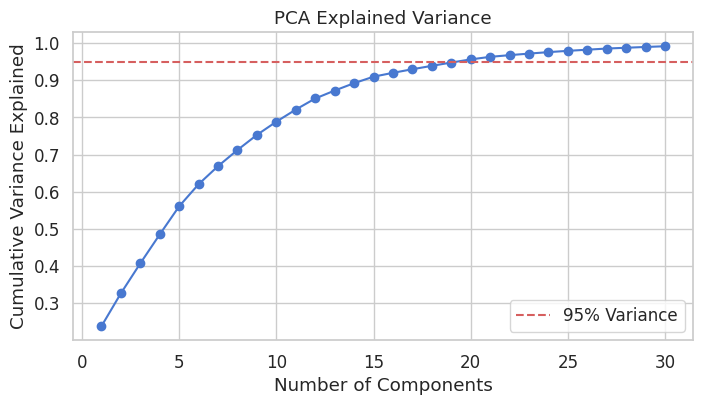

Selected n_components: 15
Training OC-SVM on PCA features...

--- OC-SVM on PCA Data (n=15) ---
              precision    recall  f1-score   support

      Normal       0.48      0.79      0.60      2152
     Anomaly       0.80      0.50      0.62      3674

    accuracy                           0.61      5826
   macro avg       0.64      0.64      0.61      5826
weighted avg       0.68      0.61      0.61      5826



In [ ]:
# --- Task 3.5: PCA + OC-SVM ---

from sklearn.decomposition import PCA

# 1. PCA Analysis (Elbow Method)
# Fit on Normal Training Data Only
pca_test = PCA(n_components=30) # Test top 30 components first
pca_test.fit(X_train_normal)

# Plot Explained Variance
plt.figure(figsize=(8, 4))
plt.plot(range(1, 31), np.cumsum(pca_test.explained_variance_ratio_), marker='o')
plt.axhline(0.95, color='r', linestyle='--', label='95% Variance')
plt.title("PCA Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance Explained")
plt.legend()
plt.grid(True)
plt.show()

# 2. Apply PCA with Chosen Components
# Looking at the plot (once generated), usually 10-15 components explain 95%
best_n_components = 15
print(f"Selected n_components: {best_n_components}")

pca = PCA(n_components=best_n_components)
X_train_pca = pca.fit_transform(X_train_normal)
X_test_pca = pca.transform(X_test.values) # Transform test using same PCA

# 3. Train OC-SVM on PCA Features
ocsvm_pca = OneClassSVM(kernel='rbf', gamma='scale', nu=0.01)
print("Training OC-SVM on PCA features...")
ocsvm_pca.fit(X_train_pca)

# 4. Evaluate
y_pred_pca_raw = ocsvm_pca.predict(X_test_pca)
y_pred_pca = [1 if p == -1 else 0 for p in y_pred_pca_raw]

print(f"\n--- OC-SVM on PCA Data (n={best_n_components}) ---")
print(classification_report(y_test_binary, y_pred_pca, target_names=['Normal', 'Anomaly']))

#### Q: compare results with the original OC-SVM and the OC-SVM trained using the Encoder embeddings. Describe the performance...

TODO

## Task 4 - Unsupervised Anomaly Detection and Interpretation

text

In [ ]:
# Create directory for plots
save_dir = results_path + 'images/' + 'task4_plots/'
os.makedirs(save_dir, exist_ok=True)

### K-means with little domain knowledge

Fit k-means with 4 clusters and the full training data (normal + anomalous). (Normal + 3 attack types = 4 clusters).

In [ ]:
# --- Task 4.1: K-Means Clustering & Interpretation ---

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

print("--- Running K-Means (k=4) on Full Training Data ---")

# 1. Fit K-Means
# We assume 4 clusters roughly corresponding to Normal, DoS, Probe, R2L/U2R
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_train)

# 2. Analyze Cluster Composition (Purity)
# We combine the Cluster ID with the True Attack Labels to see what's inside each cluster
df_analysis = pd.DataFrame({'cluster': cluster_labels, 'label': y_train_attack.values})

print("\n--- Cluster Composition (Purity Analysis) ---")
# Cross-tabulation: Rows=Cluster ID, Cols=True Attack Label
crosstab = pd.crosstab(df_analysis['cluster'], df_analysis['label'])
print(crosstab)

# Check for "Pure" Clusters
# A pure cluster contains mostly one type of label (e.g., 99% Normal)
for cluster_id in range(4):
    cluster_data = df_analysis[df_analysis['cluster'] == cluster_id]
    dominant_label = cluster_data['label'].mode()[0]
    purity = (cluster_data['label'] == dominant_label).sum() / len(cluster_data)
    print(f"Cluster {cluster_id}: Dominant Label = {dominant_label} ({purity:.2%} pure)")

# 3. Silhouette Analysis
# Silhouette measures how similar an object is to its own cluster (cohesion)
# compared to other clusters (separation). Range: [-1, 1].
print("\n--- Silhouette Analysis ---")
# Note: Calculating silhouette for all samples can be slow.
# If too slow, sample_size=5000 in silhouette_score
silhouette_avg = silhouette_score(X_train, cluster_labels)
sample_silhouette_values = silhouette_samples(X_train, cluster_labels)

print(f"Average Silhouette Score: {silhouette_avg:.4f}")

# Analyze Silhouette per Cluster
for i in range(4):
    # Aggregate the silhouette scores for samples belonging to cluster i
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    avg_score = np.mean(ith_cluster_silhouette_values)
    print(f"Cluster {i} Avg Silhouette: {avg_score:.4f}")

    # If silhouette is low (< 0.1 or negative), the cluster is poorly defined.
    if avg_score < 0.1:
        print(f"  -> WARNING: Cluster {i} has low separation. It likely mixes Normal/Attacks.")

--- Running K-Means (k=4) on Full Training Data ---

--- Cluster Composition (Purity Analysis) ---
label     dos  normal  probe  r2l
cluster                          
0         630    8986    819  126
1        1168      30     53    1
2         241     389    730    0
3           0       8      0    0
Cluster 0: Dominant Label = normal (85.09% pure)
Cluster 1: Dominant Label = dos (93.29% pure)
Cluster 2: Dominant Label = probe (53.68% pure)
Cluster 3: Dominant Label = normal (100.00% pure)

--- Silhouette Analysis ---
Average Silhouette Score: 0.4640
Cluster 0 Avg Silhouette: 0.4592
Cluster 1 Avg Silhouette: 0.7271
Cluster 2 Avg Silhouette: 0.2596
Cluster 3 Avg Silhouette: 0.3978


### K-means cluster interpretation

Examine the clusters to understand their quality.

#### Q: How big are the clusters? How are the attack labels distributed across the clusters? Are the clusters pure?

TODO

#### Q: How high is the silhouette per cluster? Is there any clusters with a lower silhouette value? If it is the case, what attack labels are present in these clusters?

TODO

#### Q: Use the t-SNE algorithm... Plot and report: i) t-SNE... with cluster ID. ii) t-SNE... with the attack label.

TODO

Running t-SNE on 3000 samples...
Computing t-SNE with perplexity=30...
Computing t-SNE with perplexity=50...
Computing t-SNE with perplexity=100...


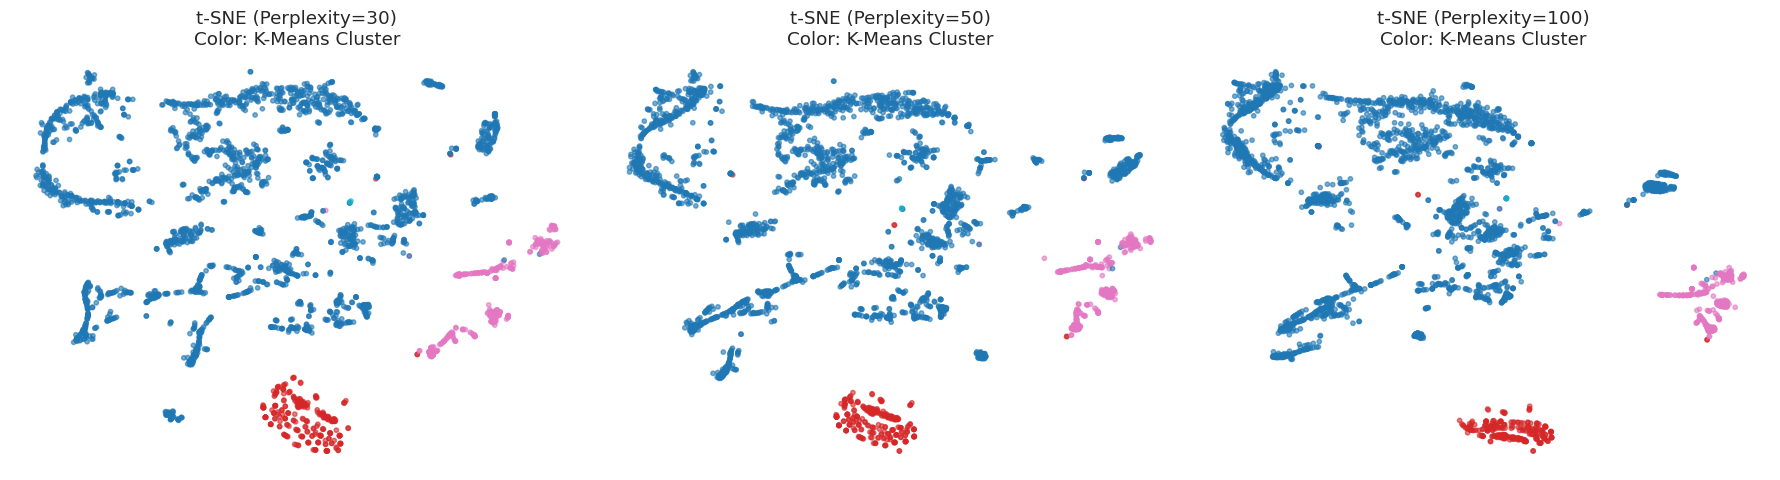

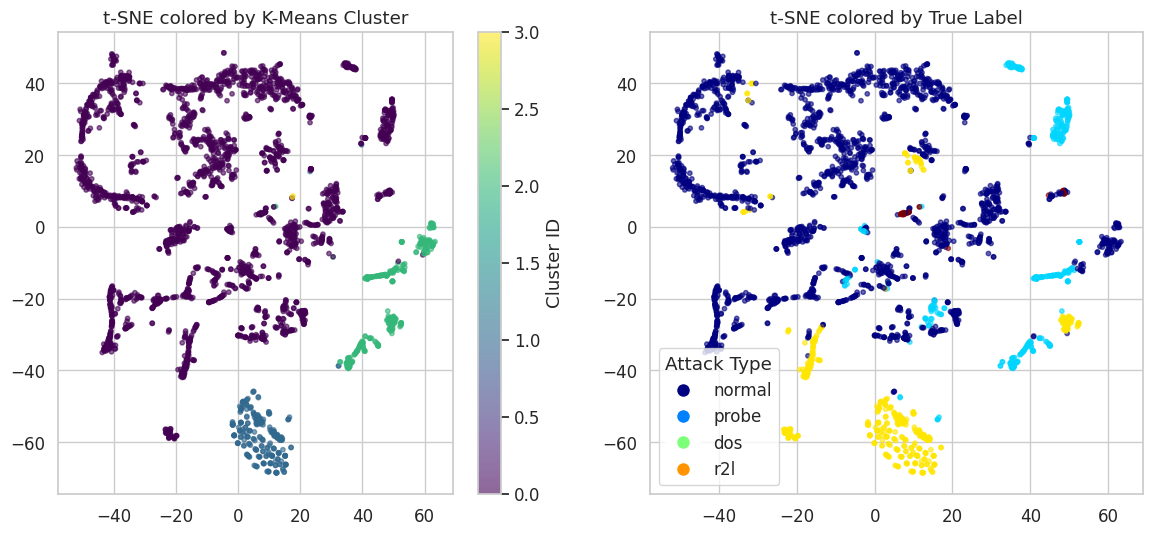

In [ ]:
# --- Task 4.2: t-SNE Visualization ---

from sklearn.manifold import TSNE

# 1. Subsample for Performance
# t-SNE is very slow on >10k points. We take a random subset of 3000 points for visualization.
n_subset = 3000
if len(X_train) > n_subset:
    indices = np.random.choice(len(X_train), n_subset, replace=False)
    X_tsne_input = X_train.iloc[indices]
    y_tsne_cluster = cluster_labels[indices] # Cluster IDs from K-Means
    y_tsne_label = y_train_attack.iloc[indices] # True Labels
else:
    X_tsne_input = X_train
    y_tsne_cluster = cluster_labels
    y_tsne_label = y_train_attack

print(f"Running t-SNE on {len(X_tsne_input)} samples...")

# 2. Try different Perplexities
# Perplexity balances attention between local and global aspects of data.
perplexities = [30, 50, 100]
best_perplexity = 30 # We will assume 30 is best for the final plot, but you should visually check
tsne_results = {}

plt.figure(figsize=(18, 5))

for i, perp in enumerate(perplexities):
    print(f"Computing t-SNE with perplexity={perp}...")
    tsne = TSNE(n_components=2, perplexity=perp, random_state=42, init='pca', learning_rate='auto')
    X_embedded = tsne.fit_transform(X_tsne_input)
    tsne_results[perp] = X_embedded

    # Plot colored by CLUSTER ID (Unsupervised View)
    plt.subplot(1, 3, i+1)
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_tsne_cluster, cmap='tab10', s=10, alpha=0.6)
    plt.title(f"t-SNE (Perplexity={perp})\nColor: K-Means Cluster")
    plt.axis('off')

plt.tight_layout()
plt.show()

# 3. Compare: Cluster ID vs True Label (Best Perplexity)
# We assume Perplexity=30 gave a good result
X_final_tsne = tsne_results[30]

plt.figure(figsize=(14, 6))

# Subplot 1: K-Means Clusters
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_final_tsne[:, 0], X_final_tsne[:, 1], c=y_tsne_cluster, cmap='viridis', s=10, alpha=0.6)
plt.title("t-SNE colored by K-Means Cluster")
plt.colorbar(scatter, label='Cluster ID')

# Subplot 2: True Attack Labels
plt.subplot(1, 2, 2)
# We need to map text labels to numbers for coloring
unique_labels = y_tsne_label.unique()
label_map = {label: i for i, label in enumerate(unique_labels)}
y_numeric = y_tsne_label.map(label_map)

scatter2 = plt.scatter(X_final_tsne[:, 0], X_final_tsne[:, 1], c=y_numeric, cmap='jet', s=10, alpha=0.6)
plt.title("t-SNE colored by True Label")

# Create a custom legend for the True Labels
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.jet(i/len(unique_labels)), markersize=10) for i in range(len(unique_labels))]
plt.legend(handles, unique_labels, title="Attack Type")

plt.show()

#### Q: Can you find a difference between the two visualizations? What are the misinterpreted points?

TODO

### DB-Scan anomalies are anomalies?

Use DB-Scan to detect anomalous patterns.

Suggested min_points (2 * dim): 228
Calculating k-distance graph for k=200...


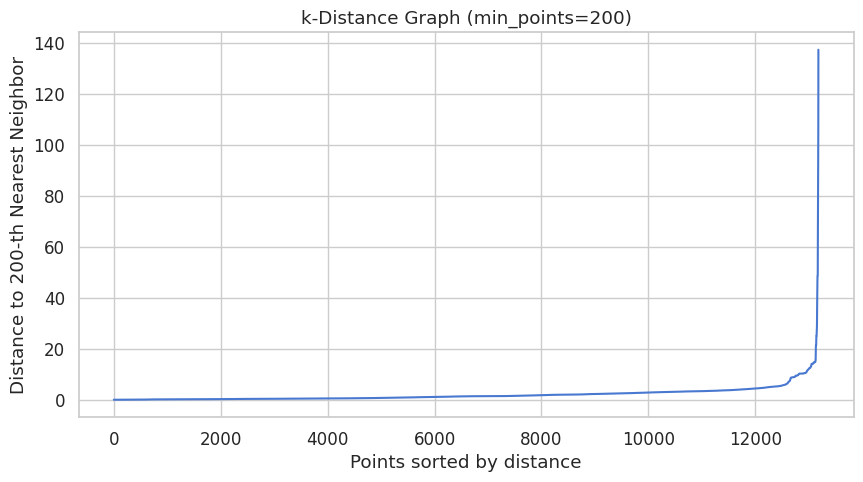

Look at the 'Elbow' in the plot (where curvature is max).
That Y-axis value is your recommended 'eps'.


In [ ]:
# --- Task 4.3: DB-Scan Parameter Estimation ---

from sklearn.neighbors import NearestNeighbors

# 1. Estimate min_points
# Heuristic 1: "Smallest pure cluster of normal data".
# Look at the K-Means crosstab output from Block 1.
# If Cluster 0 is 99% Normal and has size 500, maybe min_points could be related to that.
# Heuristic 2: Standard Rule of Thumb -> min_points approx 2 * Dimensions
dim = X_train.shape[1]
min_points_heuristic = 2 * dim # 2 * 114 = 228
print(f"Suggested min_points (2 * dim): {min_points_heuristic}")

# Let's set a reasonable value for this dataset size
min_pts = 200 # You can adjust this based on the K-means analysis

# 2. Elbow Method for Epsilon (eps)
# We calculate the distance to the k-th nearest neighbor (k=min_pts)
print(f"Calculating k-distance graph for k={min_pts}...")
neighbors = NearestNeighbors(n_neighbors=min_pts)
neighbors_fit = neighbors.fit(X_train)
distances, indices = neighbors_fit.kneighbors(X_train)

# Sort distances (we use the distance to the min_pts-th neighbor)
distances = np.sort(distances[:, min_pts-1], axis=0)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(distances)
plt.title(f"k-Distance Graph (min_points={min_pts})")
plt.xlabel("Points sorted by distance")
plt.ylabel(f"Distance to {min_pts}-th Nearest Neighbor")
plt.grid(True)
plt.show()

print("Look at the 'Elbow' in the plot (where curvature is max).")
print("That Y-axis value is your recommended 'eps'.")

In [ ]:
# --- Task 4.4: DB-Scan Execution ---

from sklearn.cluster import DBSCAN

# SET YOUR CHOSEN PARAMETERS HERE
chosen_eps = 3.0     # <--- UPDATE THIS based on the Elbow Plot
chosen_min_pts = 200 # <--- Must match what you used in Block 3

print(f"Running DBSCAN (eps={chosen_eps}, min_samples={chosen_min_pts})...")
dbscan = DBSCAN(eps=chosen_eps, min_samples=chosen_min_pts)
db_labels = dbscan.fit_predict(X_train)

# 1. Analyze Clusters
n_clusters_ = len(set(db_labels)) - (1 if -1 in db_labels else 0)
n_noise_ = list(db_labels).count(-1)

print(f"Estimated number of clusters: {n_clusters_}")
print(f"Estimated number of noise points: {n_noise_}")

# 2. Check Noise Cluster (-1) Purity
# Does the noise cluster consist mostly of anomalies?
df_db = pd.DataFrame({'db_cluster': db_labels, 'binary_label': y_train_binary.values, 'attack_label': y_train_attack.values})

# Cross-tabulation: DB-Cluster vs Binary Label (0=Normal, 1=Anomaly)
print("\n--- DBSCAN Cluster Composition ---")
print(pd.crosstab(df_db['db_cluster'], df_db['binary_label']))

# Specific Analysis of Noise Cluster (-1)
noise_data = df_db[df_db['db_cluster'] == -1]
if not noise_data.empty:
    anomalies_in_noise = noise_data[noise_data['binary_label'] == 1].shape[0]
    total_noise = noise_data.shape[0]
    print(f"\nNoise Cluster (-1) Purity:")
    print(f"Contains {anomalies_in_noise} actual anomalies out of {total_noise} points.")
    print(f"Purity (Anomalies): {anomalies_in_noise / total_noise:.2%}")

    print("\nWhat attacks are in the noise cluster?")
    print(noise_data['attack_label'].value_counts().head())
else:
    print("\nNo noise points detected. Try decreasing 'eps'.")

Running DBSCAN (eps=3.0, min_samples=200)...
Estimated number of clusters: 6
Estimated number of noise points: 1523

--- DBSCAN Cluster Composition ---
binary_label     0     1
db_cluster              
-1             689   834
 0            8456   809
 1               0   482
 2               0  1162
 3               0   233
 4             268     3
 5               0   245

Noise Cluster (-1) Purity:
Contains 834 actual anomalies out of 1523 points.
Purity (Anomalies): 54.76%

What attacks are in the noise cluster?
attack_label
normal    689
probe     641
dos       144
r2l        49
Name: count, dtype: int64


#### Q: Create the clustering results... Does the DB-Scan noise cluster (cluster -1) consist only of anomalous points (cross-reference with real attack labels)?

TODO

---

# Task
Count samples for 'protocol_type', 'service', and 'flag' in both train_df and test_df and print the value counts.

## count_categorical_features

### Subtask:
Count samples for 'protocol_type', 'service', and 'flag' in both train_df and test_df and print the value counts.


## Summary:

### Data Analysis Key Findings
*   The value counts for the categorical features 'protocol\_type', 'service', and 'flag' were calculated for both the training and testing datasets. This step is crucial for understanding the distribution and cardinality of these features across the datasets.

### Insights or Next Steps
*   Compare the distributions and unique values of these categorical features between the training and testing datasets to identify any significant discrepancies that might impact model performance or require special handling.
*   Based on the cardinality and distribution of these features, determine appropriate encoding strategies (e.g., One-Hot Encoding, Label Encoding, Target Encoding) for model training.
